<a href="https://colab.research.google.com/github/Gorzkun/Bocchi-The-Rock-Script-Analysis/blob/main/Bocchi_The_Rock_Script_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -r Bocchi-The-Rock-Script-Analysis/ #Erase the repository for any update

rm: cannot remove 'Bocchi-The-Rock-Script-Analysis/': No such file or directory


In [ ]:
!git clone https://github.com/Gorzkun/Bocchi-The-Rock-Script-Analysis #Import the repository on Github

Cloning into 'Bocchi-The-Rock-Script-Analysis'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 45 (delta 14), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (45/45), 2.38 MiB | 5.06 MiB/s, done.


In [ ]:
#Import libraries
import pandas as pd
import json
import re
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download ('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.casual import regex
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer,PorterStemmer
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
#Import script
df = pd.read_csv("/content/Bocchi-The-Rock-Script-Analysis/Script_Bocchi_The_Rock_S1.txt", sep=";")
df['Dialogue'] = df['Dialogue'].astype(str)
df.head()

Index  Season  Episode           Episode_name  Character_name  \
0      1       1        1  Lonely Rolling Bocchi        Students   
1      2       1        1  Lonely Rolling Bocchi    Hitori Gotou   
2      3       1        1  Lonely Rolling Bocchi  Teacher Kinder   
3      4       1        1  Lonely Rolling Bocchi    Hitori Gotou   
4      5       1        1  Lonely Rolling Bocchi  Teacher Picnic   

  Type_Dialogue                                           Dialogue  
0          Talk  Come over now if you wanna play hide-and-seek!...  
1   Inner Voice  The girl who wonders, Would it be okay for me ...  
2          Talk                         Hitori-chan, what's wrong?  
3   Inner Voice  The girl who ends up all alone at a picnic, sw...  
4          Talk                                       Here you go.

##1.- Exploratory Analysis

In [ ]:
# Clean text
stop_words = set(stopwords.words('english'))
# add words that aren't in the NLTK stopwords list
new_stopwords = ['thats','weve','hes','theres','ive','im','will','can','cant','dont','youve','us'
        ,'youre','youll','theyre','whats','didnt','going','one','got','get','chan','senpai','san']
new_stopwords_list = stop_words.union(new_stopwords)

# After previous text analysis, some words needed replacements in order to take part in the exploratory analysis
exception_map={
    "gonna": "going to",
    "kit-aura": "kitaura",
    " i'll":" i will",
    "y'know":"you know",
    "wanna":"want to",
    "gotta":"got to",
    "sis":"sister"}

df['Dialogue_clean'] = df['Dialogue'].apply(lambda x: x.lower())
df['Dialogue_clean'] = df['Dialogue_clean'].replace(exception_map, regex=True)
df["Dialogue_clean"] = df['Dialogue_clean'].str.replace('[^\w\s]',' ')
df.Dialogue_clean = df.Dialogue_clean.str.split().apply\
        (lambda x: ' '.join(item for item in x if item not in new_stopwords_list))
df.Dialogue_clean = df.Dialogue_clean.str.replace('  ', '')
df['Dialogue_clean'] = df['Dialogue_clean'].apply(nltk.word_tokenize)
df['NumberOfWords'] = df['Dialogue_clean'].str.len()
df.head()

<ipython-input-5-f9f4b8349569>:20: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Dialogue_clean"] = df['Dialogue_clean'].str.replace('[^\w\s]',' ')


Index  Season  Episode           Episode_name  Character_name  \
0      1       1        1  Lonely Rolling Bocchi        Students   
1      2       1        1  Lonely Rolling Bocchi    Hitori Gotou   
2      3       1        1  Lonely Rolling Bocchi  Teacher Kinder   
3      4       1        1  Lonely Rolling Bocchi    Hitori Gotou   
4      5       1        1  Lonely Rolling Bocchi  Teacher Picnic   

  Type_Dialogue                                           Dialogue  \
0          Talk  Come over now if you wanna play hide-and-seek!...   
1   Inner Voice  The girl who wonders, Would it be okay for me ...   
2          Talk                         Hitori-chan, what's wrong?   
3   Inner Voice  The girl who ends up all alone at a picnic, sw...   
4          Talk                                       Here you go.   

                                      Dialogue_clean  NumberOfWords  
0         [come, want, play, hide, seek, play, play]              7  
1  [girl, wonders, would, okay, join, misses, cha...              9  
2                                    [hitori, wrong]              2  
3  [girl, ends, alone, picnic, swapping, parts, l...              8  
4                                               [go]              1

In [ ]:
speaks_more = df.groupby('Character_name')['NumberOfWords'].agg(['sum','count'])
speaks_more = speaks_more.sort_values(by = 'sum', ascending=False)

df_unpivot = df.explode('Dialogue_clean')
df_unpivot = df_unpivot.drop(['Dialogue','Episode_name'], axis=1)
df_unpivot['Dialogue_clean'] = df_unpivot['Dialogue_clean'].astype(str)

fav_last = df_unpivot.groupby(['Character_name','Dialogue_clean']).size().reset_index(name='Frequency')
fav_last['index'] = fav_last['Character_name']+fav_last['Dialogue_clean']

fav = df_unpivot.groupby('Character_name')['Dialogue_clean'].apply(
    lambda x: x.mode().iat[0]).reset_index(name='Favourite Word')
fav['index'] = fav['Character_name']+fav['Favourite Word']
fav = pd.merge(fav,fav_last,how='inner')
fav = fav.drop(['index','Dialogue_clean'], axis=1)

final_profile = pd.merge(fav,speaks_more, on='Character_name')
final_profile = final_profile.rename(columns={'sum':'Number of Words','count':'Number of Dialogues'})

In [ ]:
final_profile = final_profile.sort_values(by='Number of Words', ascending = False)
final_profile.head(10)

Character_name Favourite Word  Frequency  Number of Words  \
19   Hitori Gotou           like         69             4859   
38  Nijika Ijichi         bocchi        119             3383   
20     Ikuyo Kita          gotoh         82             2253   
44     Ryo Yamada         bocchi         24             1081   
30   Kikuri Hiroi            hey         12              872   
50   Seika Ijichi         bocchi         11              441   
37    Naoki Gotou          right          6              192   
12   Futari Gotou         sister         11              155   
33  Michiyo Gotou        friends          7              149   
55       Students          class          4              139   

    Number of Dialogues  
19                  855  
38                  682  
20                  504  
44                  288  
30                  129  
50                  107  
37                   37  
12                   39  
33                   36  
55                   23

In [ ]:
lemmatized_words = df

lemmatizer = WordNetLemmatizer()

lemmatized_words['Lemmatized'] = lemmatized_words['Dialogue_clean'].apply(
                    lambda lst:[lemmatizer.lemmatize(word) for word in lst])

In [ ]:
speaks_more_l = lemmatized_words.groupby('Character_name')['NumberOfWords'].agg(['sum','count'])
speaks_more_l = speaks_more_l.sort_values(by = 'sum', ascending=False)
# Get a temporary dataframe in the right format for any analysis.
df_unpivot_l = lemmatized_words.explode('Lemmatized')
df_unpivot_l = df_unpivot_l.drop(['Dialogue','Episode_name','Dialogue_clean'], axis=1)
df_unpivot_l['Lemmatized'] = df_unpivot_l['Lemmatized'].astype(str)
# Get the most common word by character
fav_last_l = df_unpivot_l.groupby(['Character_name','Lemmatized']).size().reset_index(name='Frequency')
fav_last_l['index'] = fav_last_l['Character_name']+fav_last_l['Lemmatized']

fav_l = df_unpivot_l.groupby('Character_name')['Lemmatized'].apply(
    lambda x: x.mode().iat[0]).reset_index(name='Favourite Word')
fav_l['index'] = fav_l['Character_name']+fav_l['Favourite Word']
fav_l = pd.merge(fav_l,fav_last_l,how='inner')
fav_l = fav_l.drop(['index','Lemmatized'], axis=1)
# Merge the two dataframes to get a nice "Profile"
final_profile_l = pd.merge(fav_l,speaks_more_l, on='Character_name')
final_profile_l = final_profile_l.rename(columns={'sum':'Number of Words','count':'Number of Dialogues'})

In [ ]:
final_profile_l = final_profile_l.sort_values(by='Number of Words', ascending = False)
final_profile_l.head(10)

Character_name Favourite Word  Frequency  Number of Words  \
19   Hitori Gotou           like         70             4859   
38  Nijika Ijichi         bocchi        119             3383   
20     Ikuyo Kita          gotoh         82             2253   
44     Ryo Yamada         bocchi         24             1081   
30   Kikuri Hiroi           play         13              872   
50   Seika Ijichi         bocchi         11              441   
37    Naoki Gotou          right          6              192   
12   Futari Gotou         sister         11              155   
33  Michiyo Gotou         friend          7              149   
55       Students          class          4              139   

    Number of Dialogues  
19                  855  
38                  682  
20                  504  
44                  288  
30                  129  
50                  107  
37                   37  
12                   39  
33                   36  
55                   23

In [ ]:
word_evolution = lemmatized_words.explode('Lemmatized')
word_evolution = word_evolution.groupby(['Episode'])['Lemmatized'].value_counts().to_frame(name='Frequency')
word_evolution = word_evolution.pivot_table(columns='Lemmatized', values='Frequency', fill_value=0, index='Episode')
word_evolution = word_evolution.cumsum()

In [ ]:
top_total_words = lemmatized_words.explode('Lemmatized')
top_total_words = top_total_words.groupby(['Lemmatized'])['Lemmatized'].value_counts().to_frame(name='Frequency')
top_total_words = top_total_words.sort_values(by = 'Frequency', ascending=False)
top_total_words.head(10)

Frequency
Lemmatized Lemmatized           
band       band              207
like       like              204
right      right             194
bocchi     bocchi            172
let        let               132
really     really            129
yeah       yeah              116
gotoh      gotoh             103
time       time              103
guitar     guitar             96

In [ ]:
!pip install bar_chart_race

In [ ]:
import bar_chart_race as bcr

In [ ]:
bcr.bar_chart_race(df = word_evolution, title ='Bocchi The Rock Top Words',
                   n_bars = 10,
                   figsize=(8,5),
                   orientation = 'h',
                   steps_per_period=5,
                   label_bars=True,
                   bar_size=1,
                   bar_label_size=10,
                   tick_label_size=10,
                   dpi = 144,
                   title_size=15,
                   filename='Top Words Bocchi.mp4'
                   )

In [ ]:
from wordcloud import WordCloud
from PIL import Image
from wordcloud import ImageColorGenerator
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

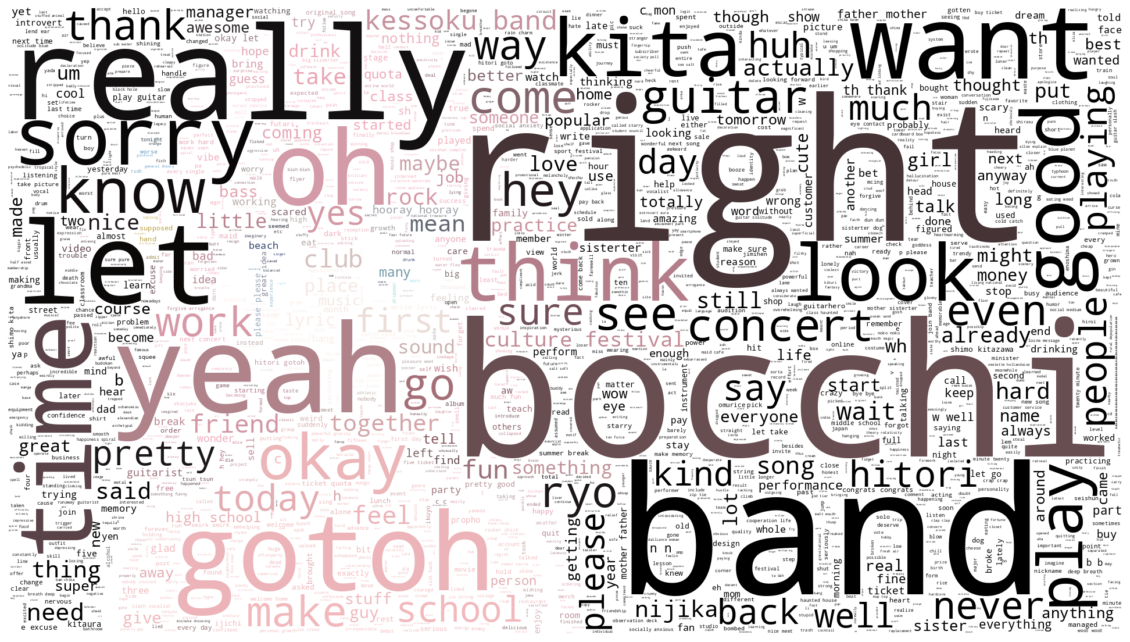

In [ ]:
word_cloud_list = lemmatized_words.explode('Lemmatized')
word_cloud_list = word_cloud_list['Lemmatized'].to_list()
word_cloud_list = pd.DataFrame(word_cloud_list, columns =['Words'])
word_cloud_list = word_cloud_list['Words'].str.cat(sep=' ')

mask_1 = np.array(Image.open("/content/Bocchi-The-Rock-Script-Analysis/Bocchi_Mask4.png"))
wordcloud_1 = WordCloud(background_color='white',mode="RGBA", max_words=2000, mask=mask_1).generate(word_cloud_list)

# create coloring from image
image_colors_2 = ImageColorGenerator(mask_1)
plt.figure(figsize=[20,20])
plt.imshow(wordcloud_1.recolor(color_func=image_colors_2), interpolation="bilinear")
plt.axis("off")

# store to file
plt.savefig("Wordcloud Bocchi.png", format="png", bbox_inches = 'tight')

plt.show()

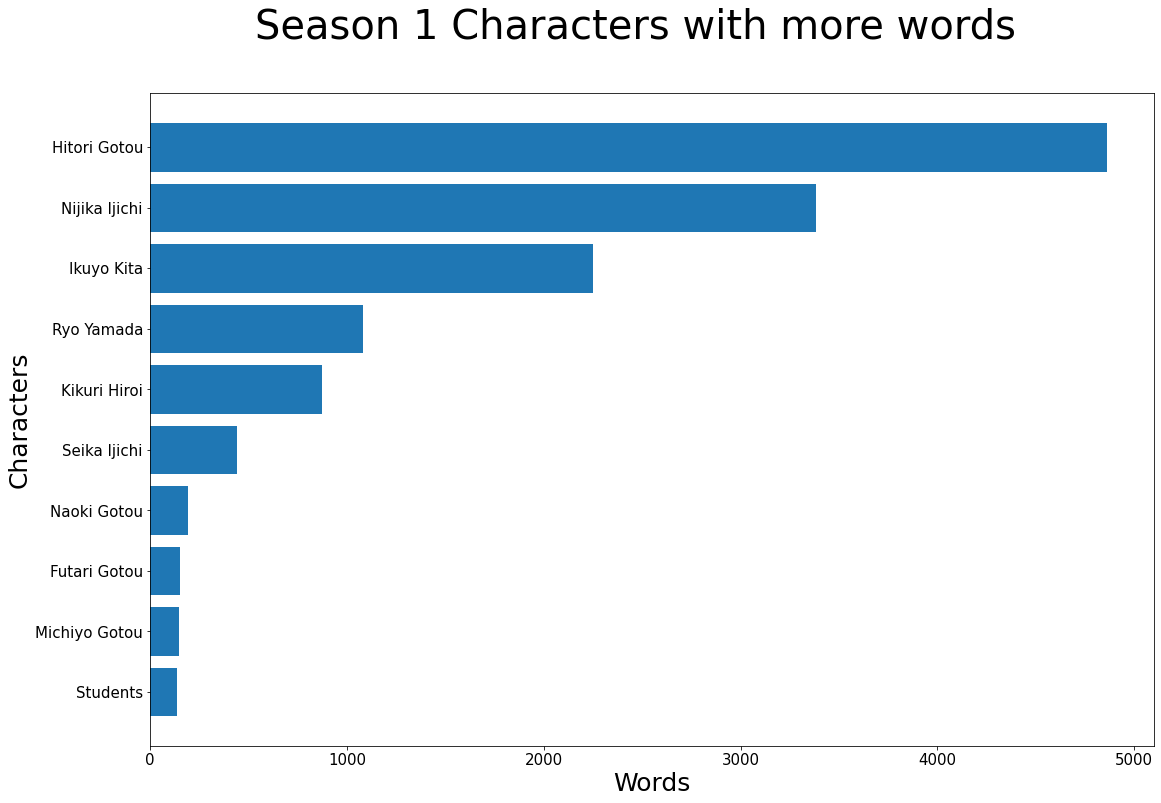

In [ ]:
#Top 12 characters with more words
top_character_w = speaks_more.sort_values(by='sum', ascending = False).head(10)
top_character_w = top_character_w.sort_values(by='sum', ascending = True)

top_character_d = speaks_more.sort_values(by='count', ascending = False).head(10)
top_character_d = top_character_d.sort_values(by='count', ascending = True)

top_character_w_labels = top_character_w.index.to_list()
top_character_words = top_character_w['sum'].to_list()

fig, ax = plt.subplots(figsize=(18,12))
fig.suptitle('Season 1 Characters with more words',fontsize=40)

ax.barh(top_character_w_labels, top_character_words)
ax.set_ylabel('Characters',fontsize=25)
ax.set_xlabel('Words',fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.savefig("Characters with more words.png", format="png", bbox_inches = 'tight')
plt.show()

In [ ]:
inner_voice = df[df["Type_Dialogue"]=="Inner Voice"]

speaks_more_revised = inner_voice.groupby('Character_name')['NumberOfWords'].agg(['sum'])
speaks_more_revised = speaks_more_revised.sort_values(by = 'sum', ascending=False)

In [ ]:
top_character_w_revised = pd.merge(top_character_w,speaks_more_revised,on='Character_name')
top_character_w_revised.columns = ['Total Words','Dialogues','Inner Words']
top_character_w_revised['%Words'] = top_character_w_revised['Inner Words']/top_character_w_revised['Total Words']

In [ ]:
top_character_w_revised

Total Words  Dialogues  Inner Words    %Words
Character_name                                               
Futari Gotou            155         39            2  0.012903
Seika Ijichi            441        107           29  0.065760
Kikuri Hiroi            872        129           36  0.041284
Ryo Yamada             1081        288            1  0.000925
Ikuyo Kita             2253        504           47  0.020861
Nijika Ijichi          3383        682           18  0.005321
Hitori Gotou           4859        855         3028  0.623173

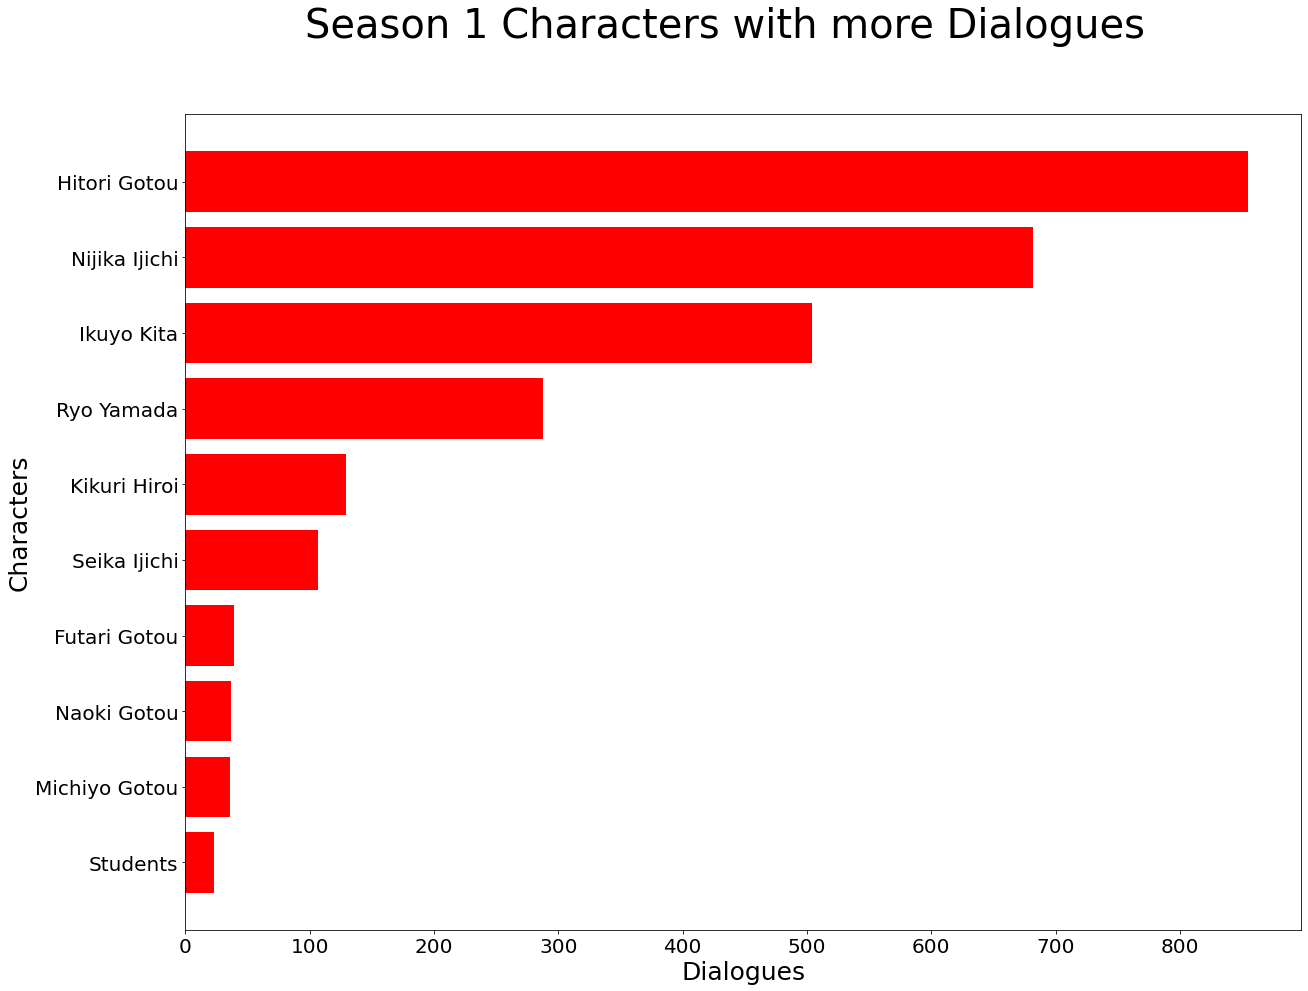

In [ ]:
#Top 12 characters with more dialogues
top_character_d_labels = top_character_d.index.to_list()
top_character_dialogue = top_character_d['count'].to_list()

fig, ax = plt.subplots(figsize=(20,15))
fig.suptitle('Season 1 Characters with more Dialogues', fontsize=40)

ax.barh(top_character_d_labels, top_character_dialogue, color ='r')
ax.set_ylabel('Characters', fontsize=25)
ax.set_xlabel('Dialogues', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)

plt.savefig("Characters with more dialogues.png", format="png", bbox_inches = 'tight')
plt.show()

In [ ]:
#To make it fun, lets do the same evolution in words, for the characters

race_characters = df.groupby(['Episode','Character_name'])['NumberOfWords'].agg(['sum','count']).reset_index()
race_characters = race_characters.sort_values(by = 'Episode', ascending=True)
print(race_characters.columns)

race_characters_w = race_characters.pivot_table(columns='Character_name', values='sum', fill_value=0, index='Episode')
race_characters_w = race_characters_w.cumsum()

Index(['Episode', 'Character_name', 'sum', 'count'], dtype='object')


In [ ]:
bcr.bar_chart_race(df = race_characters_w, title ='Bocchi The Rock Words per Character',
                   n_bars = 10,
                   label_bars= True,
                   figsize=(8,5),
                   orientation = 'h',
                   steps_per_period=4,
                   filter_column_colors = True,
                   bar_size=1,
                   bar_label_size=10,
                   tick_label_size=10,
                   dpi = 144,
                   title_size=15,
                   filename='Top Characters with more words Bocchi.mp4'
                   )

/usr/local/lib/python3.8/dist-packages/bar_chart_race/_make_chart.py:284: UserWarning: Glyph 127 () missing from current font.
  fig.canvas.print_figure(io.BytesIO())
/usr/local/lib/python3.8/dist-packages/bar_chart_race/_make_chart.py:284: UserWarning: Glyph 128 (\x80) missing from current font.
  fig.canvas.print_figure(io.BytesIO())
/usr/local/lib/python3.8/dist-packages/bar_chart_race/_make_chart.py:286: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(self.df_values.columns)
/usr/local/lib/python3.8/dist-packages/bar_chart_race/_make_chart.py:287: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))


In [ ]:
main_characters = final_profile.sort_values(by = 'Number of Words', ascending =False).head(10)
main_characters = main_characters['Character_name'].values.tolist()

main_characters_2 = final_profile.sort_values(by = 'Number of Words', ascending =False).head(25)
main_characters_2 = main_characters_2['Character_name'].values.tolist()
print(main_characters)

['Hitori Gotou', 'Nijika Ijichi', 'Ikuyo Kita', 'Ryo Yamada', 'Kikuri Hiroi', 'Seika Ijichi', 'Naoki Gotou', 'Futari Gotou', 'Michiyo Gotou', 'Students']


In [ ]:
top_words = lemmatized_words.explode('Lemmatized') #Lets use the data frame with only nouns and adjectives
top_words['Fixed_number'] = 1

top_words = top_words.groupby(['Character_name'])['Lemmatized'].value_counts().reset_index(name = 'Total')
top_words = top_words.sort_values(by = 'Total', ascending = False).groupby('Character_name', sort=False).head(5)
top_words = top_words.sort_values(by = 'Character_name', ascending= False)
top_words = top_words[top_words['Character_name'].isin(main_characters)]
top_words = top_words.groupby('Character_name')['Lemmatized'].apply(list).to_frame('Top Words')
top_words.head(15)

Top Words
Character_name                                         
Futari Gotou             [fun, yeah, play, day, sister]
Hitori Gotou                  [right, band, n, like, b]
Ikuyo Kita            [really, let, right, like, gotoh]
Kikuri Hiroi         [play, bocchi, right, hitori, hey]
Michiyo Gotou        [right, eat, friend, hitori, back]
Naoki Gotou     [hitori, really, right, better, friend]
Nijika Ijichi          [bocchi, like, right, band, let]
Ryo Yamada           [guitar, yeah, like, band, bocchi]
Seika Ijichi           [bocchi, like, work, band, need]
Students                  [oh, want, thank, hey, class]

##2.- Bigrams

In [ ]:
bigrams = df

bigrams = bigrams.drop(['Dialogue_clean','NumberOfWords'], axis=1)

In [ ]:
bigrams['Dialogue_clean'] = bigrams['Dialogue'].apply(lambda x: x.lower())
bigrams['Dialogue_clean'] = bigrams['Dialogue_clean'].replace(exception_map, regex=True)
bigrams['Dialogue_clean'] = bigrams['Dialogue_clean'].str.replace('[^\w\s]','')
bigrams.Dialogue_clean = bigrams.Dialogue_clean.str.split().apply\
        (lambda x: ' '.join(item for item in x if item not in new_stopwords_list))
bigrams.Dialogue_clean = bigrams.Dialogue_clean.str.replace('  ', '')
bigrams['Dialogue_clean'] = bigrams['Dialogue_clean'].apply(nltk.word_tokenize)

bigrams['Lemmatized'] = bigrams['Dialogue_clean'].apply(
                    lambda lst:[lemmatizer.lemmatize(word) for word in lst])

bigrams['Bigrams'] = bigrams['Lemmatized'].apply(lambda row: list(nltk.ngrams(row, 2)))
bigrams_total = bigrams.explode('Bigrams')

<ipython-input-28-5af4e1d179eb>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  bigrams['Dialogue_clean'] = bigrams['Dialogue_clean'].str.replace('[^\w\s]','')


In [ ]:
#Finally lets see the result
bigrams_fav = bigrams_total.groupby('Bigrams').size().reset_index(name='Total')
bigrams_fav = bigrams_fav.sort_values(by = 'Total', ascending=False)
bigrams_fav.head(10)

Bigrams  Total
4261      (kessoku, band)     43
1777  (culture, festival)     33
3724       (high, school)     21
2517     (father, mother)     16
4930         (look, like)     16
3910           (id, like)     12
6020          (okay, let)     12
3807     (hooray, hooray)     12
5518     (mother, father)     12
4576            (let, go)     11

In [ ]:
top_bigrams = bigrams.explode('Bigrams')
top_bigrams['Fixed_number'] = 1

top_bigrams = top_bigrams.groupby(['Character_name'])['Bigrams'].value_counts().reset_index(name = 'Total')
top_bigrams = top_bigrams.sort_values(by = 'Total', ascending = False).groupby('Character_name', sort=False).head(5)
top_bigrams = top_bigrams.sort_values(by = 'Character_name', ascending= False)
top_bigrams = top_bigrams[top_bigrams['Character_name'].isin(main_characters)]
top_bigrams = top_bigrams.groupby('Character_name')['Bigrams'].apply(list).to_frame('Top Words')

pd.set_option('display.max_colwidth', None)
top_bigrams.head(15)

Top Words
Character_name                                                                                            
Futari Gotou                     [(like, sister), (yes, please), (yes, pleasure), (stay, home), (aw, fun)]
Hitori Gotou    [(father, mother), (kessoku, band), (culture, festival), (mother, father), (high, school)]
Ikuyo Kita                 [(culture, festival), (let, go), (play, guitar), (kessoku, band), (look, like)]
Kikuri Hiroi             [(drinking, party), (want, take), (happiness, spiral), (play, street), (lem, me)]
Michiyo Gotou            [(friend, friend), (weather, nice), (time, eat), (thought, id), (think, amazing)]
Naoki Gotou           [(would, real), (youd, need), (guitar, designed), (music, really), (better, better)]
Nijika Ijichi           [(kessoku, band), (okay, let), (write, lyric), (great, idea), (culture, festival)]
Ryo Yamada                [(thank, much), (typical, bocchi), (smirk, smirk), (hooray, hooray), (id, like)]
Seika Ijichi                  [(picchu, machu), (make, sure), (machu, picchu), (kind, band), (good, work)]
Students                             [(crazy, cute), (12, maid), (hey, want), (2, haunted), (booze, sure)]

##3.- Trigram Analysis

In [ ]:
trigrams = df

trigrams = trigrams.drop(['Dialogue_clean','NumberOfWords'], axis=1)

In [ ]:
trigrams['Dialogue_clean'] = trigrams['Dialogue'].apply(lambda x: x.lower())
trigrams['Dialogue_clean'] = trigrams['Dialogue_clean'].replace(exception_map, regex=True)
trigrams['Dialogue_clean'] = trigrams['Dialogue_clean'].str.replace('[^\w\s]','')
trigrams.Dialogue_clean = trigrams.Dialogue_clean.str.split().apply\
        (lambda x: ' '.join(item for item in x if item not in new_stopwords_list))
trigrams.Dialogue_clean = trigrams.Dialogue_clean.str.replace('  ', '')
trigrams['Dialogue_clean'] = trigrams['Dialogue_clean'].apply(nltk.word_tokenize)

trigrams['Lemmatized'] = trigrams['Dialogue_clean'].apply(
                    lambda lst:[lemmatizer.lemmatize(word) for word in lst])

trigrams['Trigrams'] = trigrams['Lemmatized'].apply(lambda row: list(nltk.ngrams(row, 3)))
trigrams = trigrams.explode('Trigrams')

<ipython-input-32-346d651e0e46>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  trigrams['Dialogue_clean'] = trigrams['Dialogue_clean'].str.replace('[^\w\s]','')


In [ ]:
#Finally lets see the result
trigrams_fav = trigrams.groupby('Trigrams').size().reset_index(name='Total')
trigrams_fav = trigrams_fav.sort_values(by = 'Total', ascending=False)
trigrams_fav.head(5)

Trigrams  Total
2220     (father, mother, father)     11
5008     (mother, father, mother)     11
3398     (hooray, hooray, hooray)      8
5969     (please, please, please)      6
2221  (father, mother, sisterter)      5

##4.- Sentiment Analysis with NRC

In [ ]:
#Lets use a new dataframe
df_nrc = df
df_nrc = df_nrc.explode('Dialogue_clean')
df_nrc = df_nrc.drop(['Dialogue','NumberOfWords'], axis=1)
df_nrc = df_nrc.rename(columns={'Dialogue_clean':'Word'})

#And import the nrc text document
file_nrc = r'/content/Bocchi-The-Rock-Script-Analysis/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt'
sentiment = pd.read_csv(file_nrc, delimiter='\t',header=None)
sentiment.columns = ['Word', 'Emotion', 'isPresent']
sentiment_final = sentiment[sentiment['isPresent'] == 1]

In [ ]:
nrc_analysis = pd.merge(df_nrc,sentiment_final, on='Word') #A quick merge
anime_sentiment = nrc_analysis.groupby(['Emotion']).size().reset_index(name='Value')
anime_sentiment = anime_sentiment.set_index('Emotion').T
#Lets see the overall result.
anime_sentiment.head()

Emotion  anger  anticipation  disgust  fear  joy  negative  positive  sadness  \
Value      288           966      213   348  807       793      1421      395   

Emotion  surprise  trust  
Value         418    816

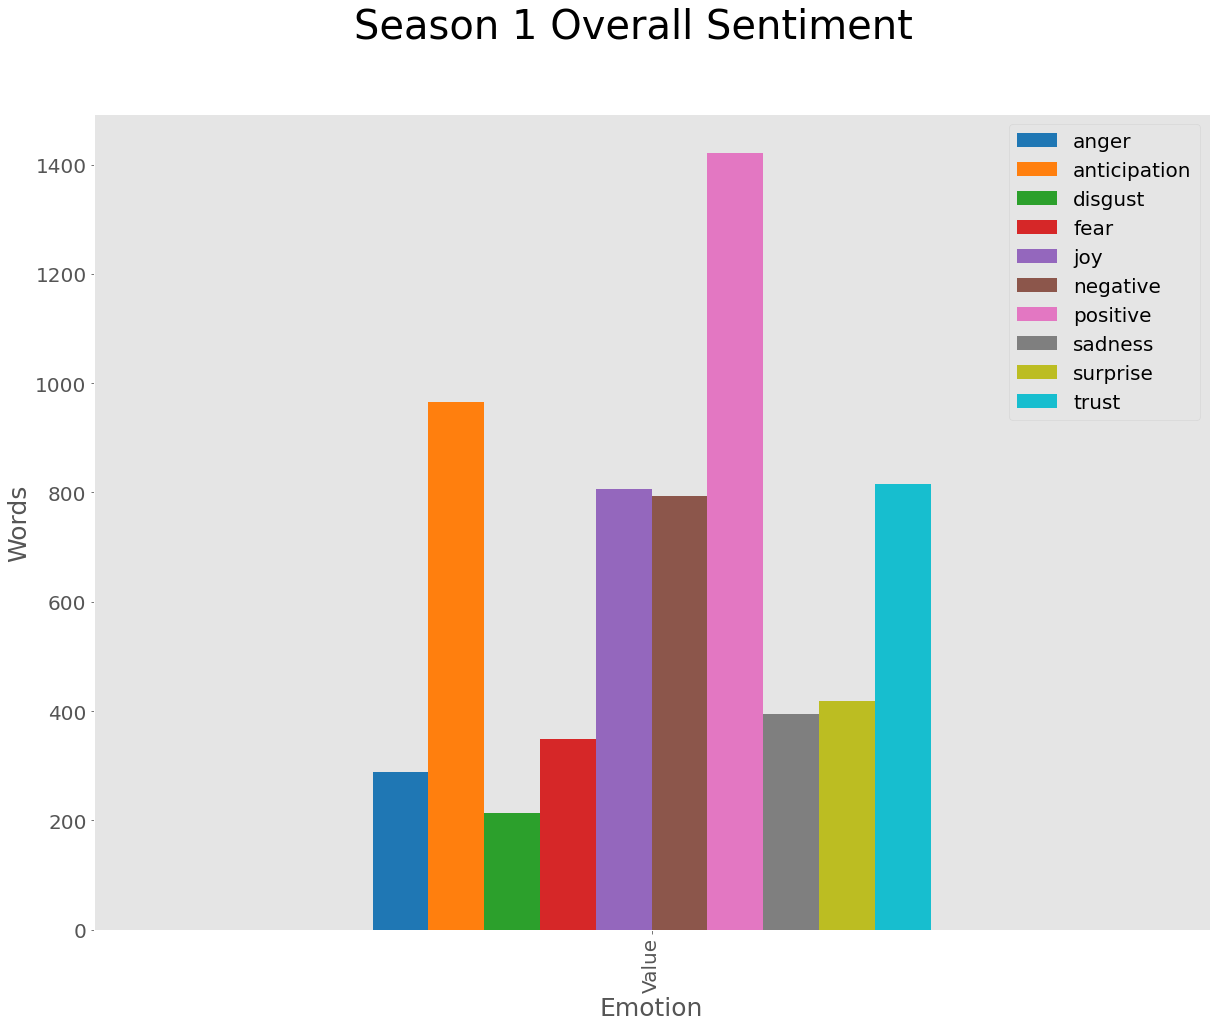

In [ ]:
plt.style.use('ggplot')
axs = anime_sentiment \
    .plot(kind='bar', figsize=(20, 15), legend=True, fontsize=20)
plt.suptitle('Season 1 Overall Sentiment', fontsize=40)
plt.legend(fontsize=20)
axs.set_xlabel("Emotion", fontsize=25)
axs.set_ylabel("Words", fontsize=25)
plt.savefig("Overall sentiment Bocchi.png", format="png", bbox_inches = 'tight')
plt.show()

In [ ]:
race_nrc_sentiment = nrc_analysis.groupby(['Episode','Emotion'])['isPresent'].sum().to_frame(name='Total')
race_nrc_sentiment = race_nrc_sentiment.pivot_table(columns='Emotion', values='Total', fill_value=0, index='Episode')
race_nrc_sentiment = race_nrc_sentiment.cumsum()

bcr.bar_chart_race(df = race_nrc_sentiment, title ='Bocchi The Rock - Overall Sentiment',
                   n_bars = 10,
                   label_bars= True,
                   figsize=(8,5),
                   orientation = 'v',
                   fixed_order = True,
                   steps_per_period=4,
                   filter_column_colors = True,
                   filename='Overallsentiment Bocchi.mp4')

/usr/local/lib/python3.8/dist-packages/bar_chart_race/_make_chart.py:294: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.df_values.columns, ha='right')
/usr/local/lib/python3.8/dist-packages/bar_chart_race/_make_chart.py:295: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([max_val] * len(ax.get_yticks()))
/usr/local/lib/python3.8/dist-packages/bar_chart_race/_make_chart.py:260: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation=30)


<ipython-input-38-b72c8eadc045>:19: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(ax, labels=labels, loc='upper right', bbox_to_anchor=(1.9,3.4), fontsize=15)


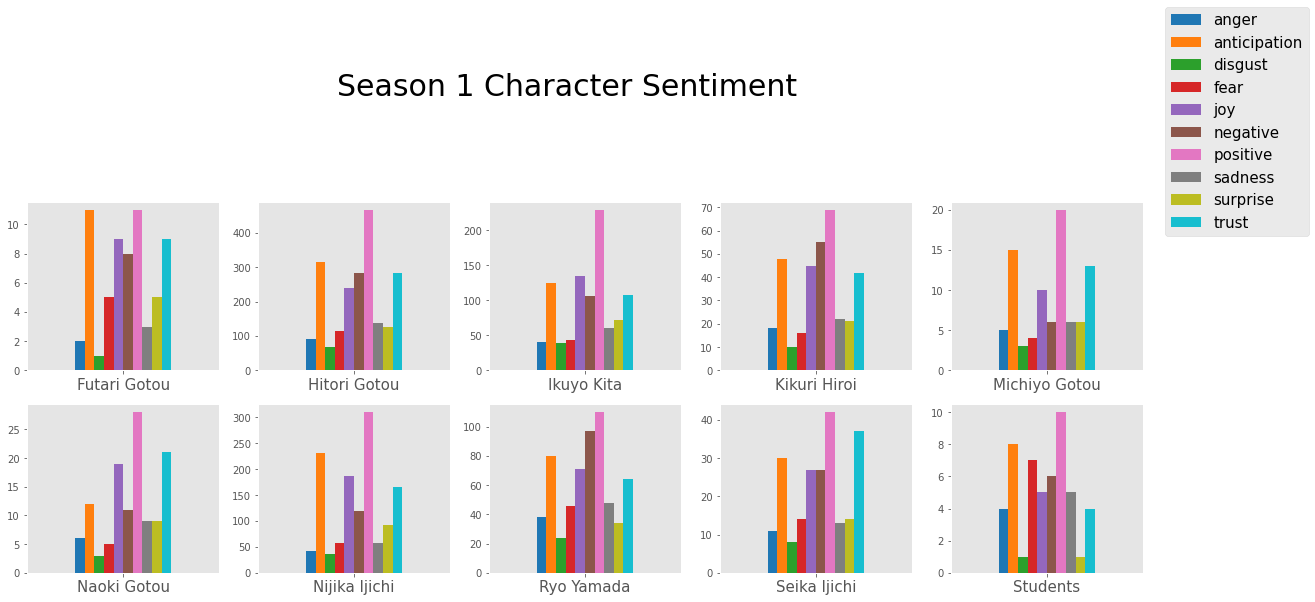

In [ ]:
character_sentiment = nrc_analysis[nrc_analysis['Character_name'].isin(main_characters)]
character_sentiment = character_sentiment.groupby(['Character_name','Emotion']).size().reset_index(name='Value')
character_sentiment = character_sentiment.pivot_table(columns='Emotion', values='Value', fill_value=0, index='Character_name')

main_character2 = character_sentiment.index.tolist() #I needed a fixed order, so I created a new list
labels = character_sentiment.columns.tolist()

plt.figure(figsize=(20,18))
plt.subplots_adjust(hspace=0.2)
plt.suptitle("Season 1 Character Sentiment", fontsize=30)

for n, char in enumerate(main_character2):
  ax = plt.subplot(5,5,n+1)
  character_sentiment[character_sentiment.index==char].plot(kind='bar',ax=ax)
  ax.set_xlabel('')
  ax.set_xticklabels(ax.get_xticklabels(),rotation=0, fontsize=15)
  ax.legend().remove()

plt.legend(ax, labels=labels, loc='upper right', bbox_to_anchor=(1.9,3.4), fontsize=15)

plt.savefig("Sentiment by character Bocchi.png", format="png", bbox_inches = 'tight')
plt.show()

In [ ]:
#Finally to show a quick example of what words are responsible for generating those emotions
word_sentiment = nrc_analysis
word_sentiment = word_sentiment.groupby(['Word'])['Emotion'].value_counts().reset_index(name = 'Total')
word_sentiment = word_sentiment.sort_values(by = 'Total', ascending = False).groupby('Emotion', sort=False).head(5)
word_sentiment = word_sentiment.groupby('Emotion')['Word'].apply(list).to_frame('Examples')
word_sentiment.head(10)

Examples
Emotion                                            
anger             [money, bad, words, feeling, hit]
anticipation    [time, good, pretty, fun, festival]
disgust        [bad, feeling, weird, powerful, mad]
fear            [bad, watch, feeling, broke, crazy]
joy             [good, pretty, fun, kind, festival]
negative         [wait, mother, excuse, wrong, bad]
positive        [good, pretty, fun, kind, festival]
sadness         [music, mother, bad, late, feeling]
surprise      [good, festival, money, break, guess]
trust           [good, school, pretty, kind, money]

##5.- Sentiment Analysis with Vader

In [ ]:
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
#Lets import vader
sid=nltk.sentiment.vader.SentimentIntensityAnalyzer()

sentiment_analysis_vader = df
sentiment_analysis_vader = sentiment_analysis_vader.drop(['Dialogue_clean','NumberOfWords'], axis=1)
sentiment_analysis_vader["Dialogue"] = sentiment_analysis_vader["Dialogue"].str.replace('[^\w\s]','')

<ipython-input-41-55cd0915b663>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  sentiment_analysis_vader["Dialogue"] = sentiment_analysis_vader["Dialogue"].str.replace('[^\w\s]','')


In [ ]:
sentiment_analysis_vader['Score']=sentiment_analysis_vader['Dialogue'].apply(lambda x: sid.polarity_scores(x))

# Place scores in own columns
sentiment_analysis_vader['CompScore']=sentiment_analysis_vader.Score.apply(lambda x: x.get("compound"))
sentiment_analysis_vader['PosScore']=sentiment_analysis_vader.Score.apply(lambda x: x.get("pos"))
sentiment_analysis_vader['NegScore']=sentiment_analysis_vader.Score.apply(lambda x: x.get("neg"))
sentiment_analysis_vader['NeuScore']=sentiment_analysis_vader.Score.apply(lambda x: x.get("neu"))

# With scores extracted, the original score field can be removed
sentiment_analysis_vader = sentiment_analysis_vader.drop(['Score'], axis=1)

# Adding Sentiment Flags
sentiment_analysis_vader['PosFlag'] = sentiment_analysis_vader.CompScore.apply(lambda x: 1 if x >= 0.05 else 0)
sentiment_analysis_vader['NegFlag'] = sentiment_analysis_vader.CompScore.apply(lambda x: 1 if x <= -0.05 else 0)
sentiment_analysis_vader['NeuFlag'] = sentiment_analysis_vader.CompScore.apply(lambda x: 1 if x < 0.05 and x > -0.05 else 0)

# Confirm scores are present and flag is functional
sentiment_analysis_vader.head()

Index  Season  Episode           Episode_name  Character_name  \
0      1       1        1  Lonely Rolling Bocchi        Students   
1      2       1        1  Lonely Rolling Bocchi    Hitori Gotou   
2      3       1        1  Lonely Rolling Bocchi  Teacher Kinder   
3      4       1        1  Lonely Rolling Bocchi    Hitori Gotou   
4      5       1        1  Lonely Rolling Bocchi  Teacher Picnic   

  Type_Dialogue  \
0          Talk   
1   Inner Voice   
2          Talk   
3   Inner Voice   
4          Talk   

                                                                                               Dialogue  \
0                                   Come over now if you wanna play hideandseek Me Ill play Me Ill play   
1  The girl who wonders Would it be okay for me to join in and so misses her chance ending up all alone   
2                                                                                Hitorichan whats wrong   
3               The girl who ends up all alone at a picnic swapping parts of her lunch with the teacher   
4                                                                                           Here you go   

                                                       Lemmatized  CompScore  \
0                      [come, want, play, hide, seek, play, play]     0.1531   
1  [girl, wonder, would, okay, join, miss, chance, ending, alone]     0.2198   
2                                                 [hitori, wrong]    -0.4767   
3      [girl, end, alone, picnic, swapping, part, lunch, teacher]    -0.2500   
4                                                            [go]     0.0000   

   PosScore  NegScore  NeuScore  PosFlag  NegFlag  NeuFlag  
0     0.330     0.257     0.413        1        0        0  
1     0.228     0.161     0.610        1        0        0  
2     0.000     0.608     0.392        0        1        0  
3     0.000     0.111     0.889        0        1        0  
4     0.000     0.000     1.000        0        0        1

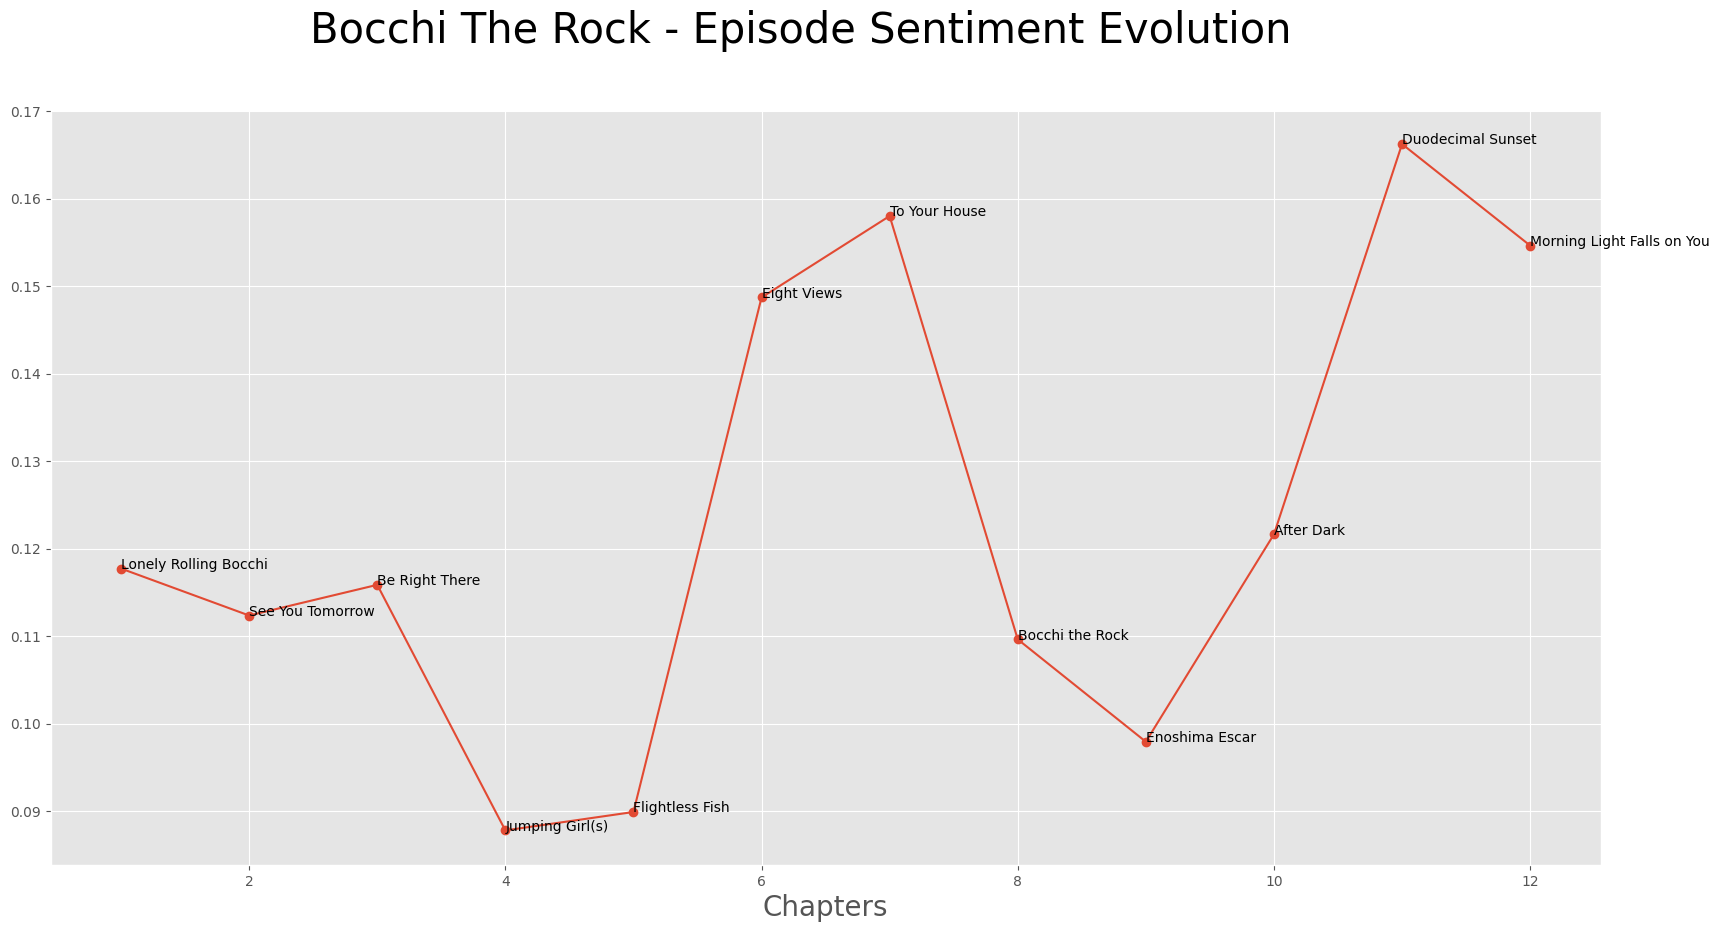

In [ ]:
#What about the mean of each chapter?
chapter_evolution_vader = sentiment_analysis_vader.groupby(['Episode','Episode_name']).mean()['CompScore'].reset_index(name='sum')
chapter_evolution_vader = chapter_evolution_vader.rename(columns={'sum':'Sentiment'})
chapter_evolution_vader = chapter_evolution_vader.set_index('Episode')
chapter_evolution_vader.index.name = None

fig_vader = plt.figure(figsize=(20,10), dpi=100)
ax = fig_vader.suptitle('Bocchi The Rock - Episode Sentiment Evolution', size=(30))
ax = fig_vader.add_subplot(111)
plt.xlabel('Chapters', size=(20))
plt.plot(chapter_evolution_vader['Sentiment'], marker='o')

for (index, episode, sentiment) in zip(chapter_evolution_vader.index,chapter_evolution_vader['Episode_name'],chapter_evolution_vader['Sentiment']):
    ax.annotate(str(episode), xy=(index, sentiment))

plt.savefig("Sentiment evolution Bocchi.png", format="png", bbox_inches = 'tight')
plt.show()

In [ ]:
chapter_evolution_vader

Episode_name  Sentiment
1        Lonely Rolling Bocchi   0.117714
2             See You Tomorrow   0.112345
3               Be Right There   0.115852
4              Jumping Girl(s)   0.087784
5              Flightless Fish   0.089887
6                  Eight Views   0.148697
7                To Your House   0.158009
8              Bocchi the Rock   0.109621
9               Enoshima Escar   0.097919
10                  After Dark   0.121626
11           Duodecimal Sunset   0.166235
12  Morning Light Falls on You   0.154631

In [ ]:
import seaborn as sns

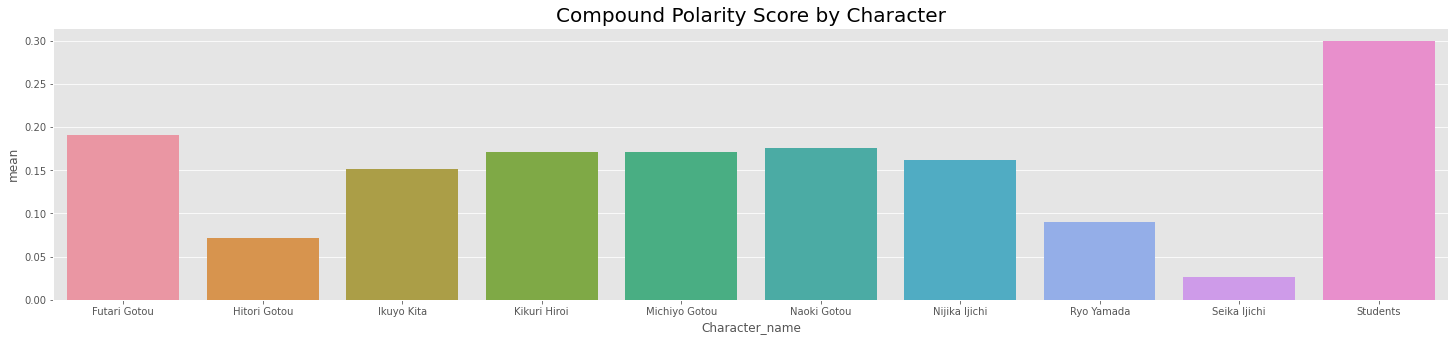

In [ ]:
vader_character = sentiment_analysis_vader.groupby(['Character_name']).mean()['CompScore'].reset_index(name='mean')
vader_character = vader_character[vader_character['Character_name'].isin(main_characters)]


fig, ax = pyplot.subplots(figsize=(25,5))
sns.barplot(ax=ax, data=vader_character, x = 'Character_name', y = 'mean')
ax.set_title('Compound Polarity Score by Character', size=20)
plt.savefig("polarity by character Bocchi.png", format="png", bbox_inches = 'tight')
plt.show()

In [ ]:
vader_character

Character_name      mean
12   Futari Gotou  0.191308
19   Hitori Gotou  0.071881
20     Ikuyo Kita  0.152072
30   Kikuri Hiroi  0.171022
33  Michiyo Gotou  0.171647
37    Naoki Gotou  0.175986
38  Nijika Ijichi  0.161853
44     Ryo Yamada  0.090500
50   Seika Ijichi  0.026274
55       Students  0.299878

In [ ]:
protagonist = ['Hitori Gotou','Ikuyo Kita','Nijika Ijichi','Ryo Yamada']

character_evolution_vader = sentiment_analysis_vader.groupby(['Episode','Character_name']).mean()['CompScore'].reset_index(name='sum')
character_evolution_vader = character_evolution_vader.rename(columns={'sum':'Sentiment'})
character_evolution_vader = character_evolution_vader[character_evolution_vader['Character_name'].isin(protagonist)]
character_evolution_vader['Episode'] = character_evolution_vader['Episode'].astype(int)
character_evolution_vader['Cummulative_Sentiment'] = (character_evolution_vader.groupby(['Character_name'])['Sentiment']
                                          .apply(lambda x: x.cumsum()))
character_evolution_vader = character_evolution_vader.sort_values(['Episode','Character_name'], ascending=[True,False])
#character_evolution = character_evolution.pivot_table(columns='Character_name', values='Cummulative_Sentiment', fill_value=0, index='Episode')
character_evolution_vader.head()

Episode Character_name  Sentiment  Cummulative_Sentiment
10        1     Ryo Yamada   0.090126               0.090126
8         1  Nijika Ijichi   0.144667               0.144667
3         1     Ikuyo Kita  -0.076550              -0.076550
2         1   Hitori Gotou   0.089349               0.089349
33        2     Ryo Yamada   0.091013               0.181139

In [ ]:
character_evolution_vader.head(48)

Episode Character_name  Sentiment  Cummulative_Sentiment
10         1     Ryo Yamada   0.090126               0.090126
8          1  Nijika Ijichi   0.144667               0.144667
3          1     Ikuyo Kita  -0.076550              -0.076550
2          1   Hitori Gotou   0.089349               0.089349
33         2     Ryo Yamada   0.091013               0.181139
31         2  Nijika Ijichi   0.185341               0.330007
24         2     Ikuyo Kita   0.000000              -0.076550
23         2   Hitori Gotou   0.040385               0.129735
44         3     Ryo Yamada  -0.075007               0.106132
42         3  Nijika Ijichi   0.092566               0.422573
39         3     Ikuyo Kita   0.169895               0.093345
38         3   Hitori Gotou   0.077904               0.207639
53         4     Ryo Yamada   0.028560               0.134693
52         4  Nijika Ijichi   0.203779               0.626352
50         4     Ikuyo Kita   0.035243               0.128589
49         4   Hitori Gotou   0.070112               0.277751
62         5     Ryo Yamada   0.039889               0.174581
60         5  Nijika Ijichi   0.130299               0.756650
57         5     Ikuyo Kita   0.108728               0.237317
56         5   Hitori Gotou   0.061829               0.339580
75         6     Ryo Yamada   0.111564               0.286145
72         6  Nijika Ijichi   0.272306               1.028956
68         6     Ikuyo Kita   0.340958               0.578275
67         6   Hitori Gotou   0.074150               0.413730
84         7     Ryo Yamada   0.160070               0.446215
81         7  Nijika Ijichi   0.172537               1.201494
78         7     Ikuyo Kita   0.189758               0.768034
77         7   Hitori Gotou   0.094747               0.508476
99         8     Ryo Yamada   0.198146               0.644361
97         8  Nijika Ijichi   0.215721               1.417215
92         8     Ikuyo Kita   0.134525               0.902559
91         8   Hitori Gotou   0.006665               0.515142
116        9     Ryo Yamada   0.111663               0.756024
115        9  Nijika Ijichi   0.088749               1.505963
111        9     Ikuyo Kita   0.097260               0.999819
110        9   Hitori Gotou   0.107671               0.622812
133       10     Ryo Yamada   0.138738               0.894762
131       10  Nijika Ijichi   0.168418               1.674382
127       10     Ikuyo Kita   0.115771               1.115590
126       10   Hitori Gotou   0.144547               0.767359
151       11     Ryo Yamada   0.084756               0.979518
149       11  Nijika Ijichi   0.152490               1.826872
145       11     Ikuyo Kita   0.260826               1.376416
144       11   Hitori Gotou   0.109084               0.876443
167       12     Ryo Yamada   0.224371               1.203889
165       12  Nijika Ijichi   0.205541               2.032413
157       12     Ikuyo Kita   0.223477               1.599893
156       12   Hitori Gotou  -0.034430               0.842013

In [ ]:
import plotly.express as px

In [ ]:
sentiment_fig_vader = px.scatter(character_evolution_vader, x = 'Episode', y = 'Cummulative_Sentiment',
                           color = 'Character_name',
                           #color_discrete_sequence = legend_colors,
                           hover_data = ['Episode'],
                           trendline = 'lowess',
                           width = 1250, height = 650)

# Customize titles.
sentiment_fig_vader.update_layout(title = {'text': "Character sentiment evolution per episode",
                                     'x': 0.5,
                                     'xanchor': 'center'},
                            xaxis_title = "Episode number",
                            yaxis_title = "Sentiment",
                            legend_title = "Characters")

# Correct position of x points.
for scatter, trendline in zip(sentiment_fig_vader.data[::2], sentiment_fig_vader.data[1::2]):
    trendline['x'] = scatter['x'][np.logical_not(np.isnan(scatter['y']))]

sentiment_fig_vader.show()

##6.- Heatmap with similarities

In [ ]:
heat_df = df[(df['Character_name']=='Hitori Gotou')|(df['Character_name']=='Ikuyo Kita')|
             (df['Character_name']=='Nijika Ijichi')|(df['Character_name']=='Ryo Yamada')|
             (df['Character_name']=='Seika Ijichi')|(df['Character_name']=='Futari Gotou')|
             (df['Character_name']=='Michiyo Gotou')|(df['Character_name']=='Naoki Gotou')]

In [ ]:
def corpus_creator(name):
    st = "" 
    for i in heat_df["Dialogue"][heat_df["Character_name"]==name]:
        st = st + i
    return st

corpus_df = pd.DataFrame()
corpus_df["Character"] = list(heat_df["Character_name"].value_counts().head(12).index)

li = []
for i in corpus_df["Character"]:
    li.append(corpus_creator(i)+" ")

corpus_df["Dialogues"] = li

corpus_df

Character  \
0   Hitori Gotou   
1  Nijika Ijichi   
2     Ikuyo Kita   
3     Ryo Yamada   
4   Seika Ijichi   
5   Futari Gotou   
6    Naoki Gotou   
7  Michiyo Gotou   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [ ]:
# from sklearn.feature_extraction import text
# punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
# stop_words = text.ENGLISH_STOP_WORDS.union(punc)

In [ ]:
# def text_processor(dialogue):
#     dialogue = word_tokenize(dialogue)
#     nopunc=[word.lower() for word in dialogue if word not in stop_words]
#     nopunc=' '.join(nopunc)
#     return [word for word in nopunc.split()]

In [ ]:
# corpus_df["Dialogues"] = corpus_df["Dialogues"].apply(lambda x: text_processor(x))
# corpus_df

In [ ]:
corpus_df['Dialogues'] = corpus_df['Dialogues'].apply(lambda x: x.lower())
corpus_df['Dialogues'] = corpus_df['Dialogues'].replace(exception_map, regex=True)
corpus_df['Dialogues'] = corpus_df['Dialogues'].str.replace('[^\w\s]',' ')
corpus_df['Dialogues'] = corpus_df['Dialogues'].str.split().apply\
        (lambda x: ' '.join(item for item in x if item not in new_stopwords_list))
corpus_df['Dialogues'] = corpus_df['Dialogues'].str.replace('  ', '')
corpus_df['Dialogues'] = corpus_df['Dialogues'].apply(nltk.word_tokenize)
corpus_df

<ipython-input-55-63149bf16441>:3: FutureWarning:

The default value of regex will change from True to False in a future version.



Character  \
0   Hitori Gotou   
1  Nijika Ijichi   
2     Ikuyo Kita   
3     Ryo Yamada   
4   Seika Ijichi   
5   Futari Gotou   
6    Naoki Gotou   
7  Michiyo Gotou   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Dialogues  
0                                      [girl, wonders, would, okay, join, misses, chance, ending, alone, girl, ends, alone, picnic, swapping, parts, lunch, teacher, home, girl, join, clubs, comes, home, right, school, finds, smartphone, full, nothing, messages, parents, coupon, offers, hitori, goto, first, year, middle, school, sometimes, think, really, change, way, always, stammer, try, speak, really, bad, keeping, eye, contact, life, archetypal, introvert, seems, fit, best, nah, dad, use, guitar, th, thanks, maybe, even, someone, like, shine, band, made, mind, learn, play, guitar, form, band, school, e, g, english, play, culture, festival, everyone, go, crazy, crazy, practiced, six, hours, every, day, could, learn, play, front, people, result, ...]  
1                                               [guitar, guitar, right, play, hello, hey, sorry, ambush, nijika, ijichi, second, year, shimo, kitazawa, high, tell, hitori, good, guitar, really, say, kind, fix, okay, really, okay, real, fix, okay, come, right, please, play, second, guitar, band, today, concert, coming, guitarist, split, song, hard, pick, right, away, please, please, thanks, let, head, club, come, shimo, kita, lot, hitori, almost, club, oh, walking, fast, club, play, called, starry, big, sisterter, manager, working, part, time, hitori, actually, pretty, athletic, see, might, made, mistake, choosing, place, good, morning, okay, hitori, band, playing, today, might, little, older, done, rehearse, pa, wrong, ryo, hitori, goto, hitori, ...]  
2                                              [guitar, sorry, sorry, hey, sure, thing, sound, gotoh, class, 2, right, looking, someone, became, human, beatbox, er, bam, chika, boom, chika, bam, chika, boom, chika, w, wait, awesome, worried, ran, like, incredible, amazing, guitar, gotoh, song, playing, totally, enraptured, band, hey, play, stuff, want, hear, oh, trying, talk, someone, earlier, right, oh, sorry, gotoh, join, band, oh, problem, anything, want, band, parties, hard, truth, actually, play, guitar, another, band, long, ago, lied, joined, wanted, close, whole, thing, beyond, ran, away, yeah, playing, strum, strum, stuff, right, figured, wooden, stick, part, decoration, way, hard, someone, learn, major, chords, minor, baseball, someone, ...]  
3                    [finally, back, oh, actually, way, manager, told, practice, time, instead, snuck, club, mad, went, shopping, gorilla, good, okay, boo, give, bonk, bass, bonk, rock, nijika, friend, know, good, music, bad, force, usually, play, comes, recommendations, lot, seen, really, excellent, problem, stood, scared, could, play, suddenly, outgoing, hitori, hitoribocchi, alone, bocchi, likes, kessoku, band, brilliant, cute, yeah, right, intro, bombed, dramatic, declaration, growth, sorry, sleepy, wait, want, watch, little, longer, brought, occasion, dun, dun, dun, dun, dun, proceed, chose, cause, close, home, two, hours, yeah, nijika, tafm, like, techno, kayo, lately, checking, saudi, arabian, charts, true, since, named, zip, ties, serve, ...]  
4          

In [ ]:
corpus_df["Length"] = corpus_df["Dialogues"].apply(lambda x: len(x))
corpus_df

Character  \
0   Hitori Gotou   
1  Nijika Ijichi   
2     Ikuyo Kita   
3     Ryo Yamada   
4   Seika Ijichi   
5   Futari Gotou   
6    Naoki Gotou   
7  Michiyo Gotou   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Dialogues  \
0                                      [girl, wonders, would, okay, join, misses, chance, ending, alone, girl, ends, alone, picnic, swapping, parts, lunch, teacher, home, girl, join, clubs, comes, home, right, school, finds, smartphone, full, nothing, messages, parents, coupon, offers, hitori, goto, first, year, middle, school, sometimes, think, really, change, way, always, stammer, try, speak, really, bad, keeping, eye, contact, life, archetypal, introvert, seems, fit, best, nah, dad, use, guitar, th, thanks, maybe, even, someone, like, shine, band, made, mind, learn, play, guitar, form, band, school, e, g, english, play, culture, festival, everyone, go, crazy, crazy, practiced, six, hours, every, day, could, learn, play, front, people, result, ...]   
1                                               [guitar, guitar, right, play, hello, hey, sorry, ambush, nijika, ijichi, second, year, shimo, kitazawa, high, tell, hitori, good, guitar, really, say, kind, fix, okay, really, okay, real, fix, okay, come, right, please, play, second, guitar, band, today, concert, coming, guitarist, split, song, hard, pick, right, away, please, please, thanks, let, head, club, come, shimo, kita, lot, hitori, almost, club, oh, walking, fast, club, play, called, starry, big, sisterter, manager, working, part, time, hitori, actually, pretty, athletic, see, might, made, mistake, choosing, place, good, morning, okay, hitori, band, playing, today, might, little, older, done, rehearse, pa, wrong, ryo, hitori, goto, hitori, ...]   
2                                              [guitar, sorry, sorry, hey, sure, thing, sound, gotoh, class, 2, right, looking, someone, became, human, beatbox, er, bam, chika, boom, chika, bam, chika, boom, chika, w, wait, awesome, worried, ran, like, incredible, amazing, guitar, gotoh, song, playing, totally, enraptured, band, hey, play, stuff, want, hear, oh, trying, talk, someone, earlier, right, oh, sorry, gotoh, join, band, oh, problem, anything, want, band, parties, hard, truth, actually, play, guitar, another, band, long, ago, lied, joined, wanted, close, whole, thing, beyond, ran, away, yeah, playing, strum, strum, stuff, right, figured, wooden, stick, part, decoration, way, hard, someone, learn, major, chords, minor, baseball, someone, ...]   
3                    [finally, back, oh, actually, way, manager, told, practice, time, instead, snuck, club, mad, went, shopping, gorilla, good, okay, boo, give, bonk, bass, bonk, rock, nijika, friend, know, good, music, bad, force, usually, play, comes, recommendations, lot, seen, really, excellent, problem, stood, scared, could, play, suddenly, outgoing, hitori, hitoribocchi, alone, bocchi, likes, kessoku, band, brilliant, cute, yeah, right, intro, bombed, dramatic, declaration, growth, sorry, sleepy, wait, want, watch, little, longer, brought, occasion, dun, dun, dun, dun, dun, proceed, chose, cause, close, home, two, hours, yeah, nijika, tafm, like, techno, kayo, lately, checking, saudi, arabian, charts, true, since, named, zip, ties, serve, ...]   
4     

In [ ]:
import gensim
# Creating a dictionary for mapping every word to a number
dictionary = gensim.corpora.Dictionary(corpus_df["Dialogues"])

# Now, we create a corpus which is a list of bags of words. A bag-of-words representation for a document just lists the number of times each word occurs in the document.
corpus = [dictionary.doc2bow(bw) for bw in corpus_df["Dialogues"]]

# Now, we use tf-idf model on our corpus
tf_idf = gensim.models.TfidfModel(corpus)

# Creating a Similarity objectr
sims = gensim.similarities.Similarity('',tf_idf[corpus],num_features=len(dictionary))

# Creating a dataframe out of similarities
sim_list = []
for i in range(8):
    query = dictionary.doc2bow(corpus_df["Dialogues"][i])
    query_tf_idf = tf_idf[query]
    sim_list.append(sims[query_tf_idf])
    
corr_df = pd.DataFrame()
j=0
for i in corpus_df["Character"]:
    corr_df[i] = sim_list[j]
    j = j + 1   

/usr/local/lib/python3.8/dist-packages/gensim/similarities/docsim.py:518: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



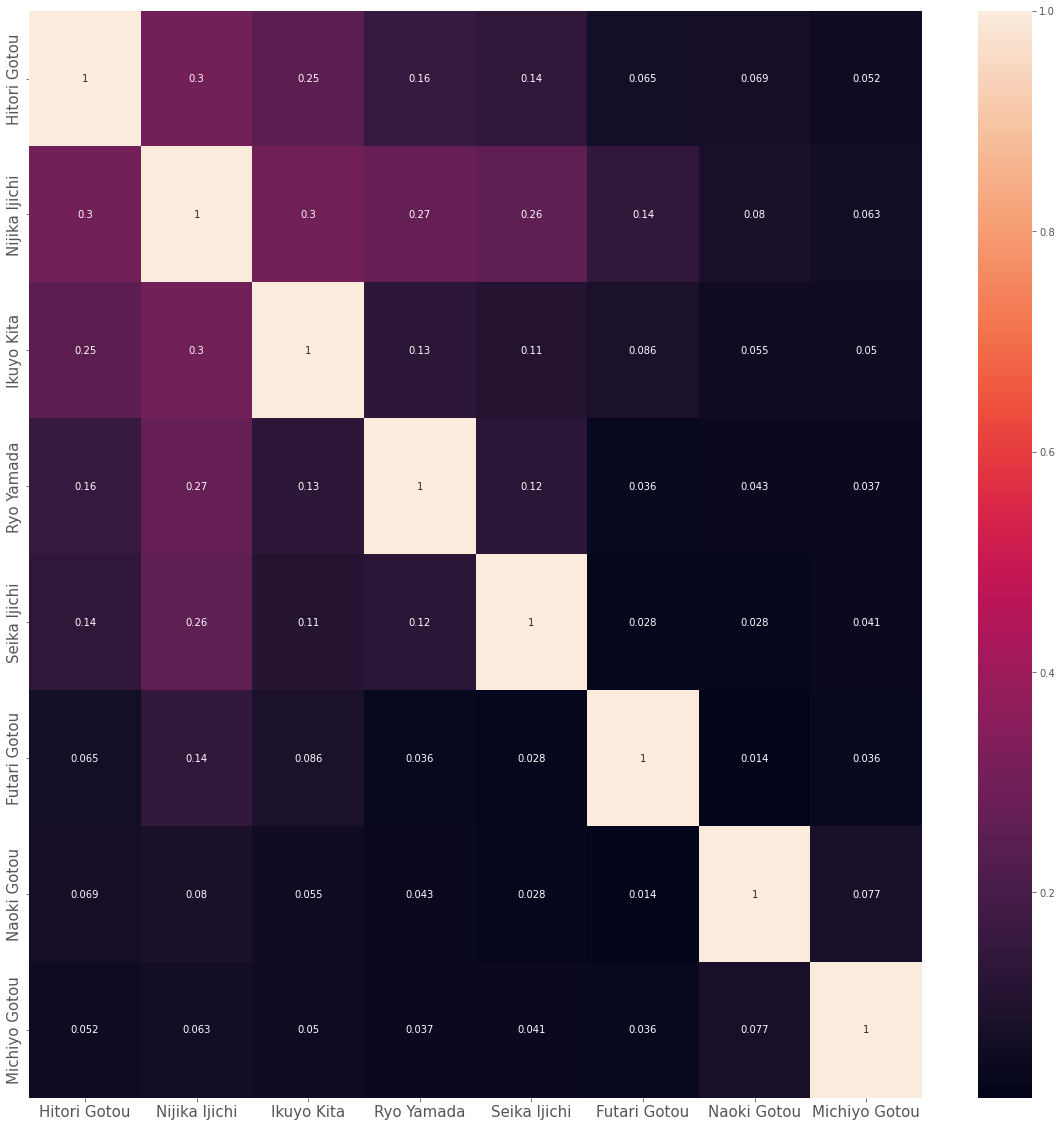

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr_df,ax=ax,annot=True)
ax.set_yticklabels(corpus_df.Character, fontsize = 15)
ax.set_xticklabels(corpus_df.Character, fontsize = 15)
plt.savefig('heat map similarity_4.png', bbox_inches = 'tight')
plt.show()

##7.- Relation Network

In [ ]:
!pip install nxviz
!pip install igraph

In [ ]:
!pip install pyvis

In [ ]:
import networkx as nx
import nxviz as nv
from nxviz import annotate
from nxviz import nodes
from nxviz import edges
from nxviz.plots import aspect_equal, despine
import igraph as ig
from pyvis.network import Network

In [ ]:
with open('/content/Bocchi-The-Rock-Script-Analysis/Relation_Network_Bocchi_The_Rock_S1.json') as f:
    data_interactions = json.load(f)
print(data_interactions['nodes'][0])
print(data_interactions['links'][0])

{'name': "Bocchi's Fans", 'value': 5, 'colour': '#EEAD0E'}
{'source': 4, 'target': 15, 'value': 9}


In [ ]:
def create_graph(data):
    G = nx.Graph()

    #build graph nodes
    for node in data['nodes']:
        G.add_node(node['name'])
        G.nodes[node['name']]['colour'] = node['colour']
        G.nodes[node['name']]['scenes'] = node['value']
        G.nodes[node['name']]['name'] = node['name']
    
    #build graph edges
    for edge in data['links']:
        G.add_edge(data['nodes'][edge['source']]['name'], data['nodes'][edge['target']]['name'], weight=edge['value']*0.25)
    
    return G

In [ ]:
G_interactions = create_graph(data_interactions)
G = [G_interactions]

In [ ]:
print('Data from the Interactions Network')
print('Number of nodes: ', G[0].number_of_nodes())
print('Number of links:', G[0].number_of_edges())

Data from the Interactions Network
Number of nodes:  16
Number of links: 89


In [ ]:
from matplotlib.colors import LinearSegmentedColormap, Normalize

In [ ]:
# Draw a graph using NetworkX
def draw_one_graph(G, title, size=25):
    fig, ax = plt.subplots(figsize=(size, size))
    pos = nx.spring_layout(G, seed=42)  # positions for all nodes

    # nodes
    options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.5}
    nx.draw_networkx_nodes(G, pos, node_color="tab:green", **options)

    # edges
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

    #labels
    nx.draw_networkx_labels(G,pos, font_size=15)

    plt.tight_layout()
    plt.title(title, fontsize=20)
    plt.axis("off")
    plt.savefig("Interaction Network Bocchi.png", dpi = 100)
    plt.show()
    

# Draws a graph with a circle structure using the nxviz library
def draw_circle_graph(G, title, size=25):
    fig, ax = plt.subplots(figsize=(size, size))
    pos = nodes.circos(G, group_by="name", color_by="colour")
    edges.circos(G, pos)
    annotate.circos_group(G, group_by="name")
    despine()
    aspect_equal()
    plt.savefig("circle graph Bocchi.png", dpi = 100)
    
# Draws a graph arranging nodes in a line and edges as arcs (using the nxviz library)
def draw_arc_graph(G, title, size=20):
    fig, ax = plt.subplots(figsize=(size, size))
    pos = nodes.arc(G, group_by="name", color_by="colour")
    edges.arc(G, pos)
    annotate.arc_group(G, group_by="name")
    despine()
    aspect_equal()
    plt.savefig("arc graph Bocchi.png", dpi = 100)
    
# Draw a graph using the igraph library (this visualization use all the node and edges features)
def draw_graph_with_features(net, size=25):
    # Rescale weight to be between 0.0 and 1.0
    scaled_weight = ig.rescale(net.es["weight"], clamp=True, out_range=(0.0,1))
    cmap2 = LinearSegmentedColormap.from_list("edge_cmap", ["darkblue", "lightpink"])

    fig, ax = plt.subplots(figsize=(size,size))
    ax.set_facecolor((247/255,247/255,247/255))
    ax.set_title('Interaction Network Bocchi The Rock', size=25)

    ig.plot(
        net,
        target=ax,
        layout="circle", # print nodes in a circular layout
        vertex_size= [num/(max(net.vs["scenes"])*5) if num > 20 else 0.05 for num in net.vs["scenes"]], #0.1,
        vertex_color=[color for color in net.vs["colour"]],
        vertex_frame_width=4.0,
        vertex_frame_color="white",
        vertex_label=net.vs["name"],
        vertex_label_color = "azure1",
        vertex_label_size = 12,
        edge_width=net.es["weight"],
        edge_color= [cmap2(value) for value in scaled_weight]
    )
    plt.savefig("Interaction Network Bocchi_2.png", dpi = 100)

    plt.show()

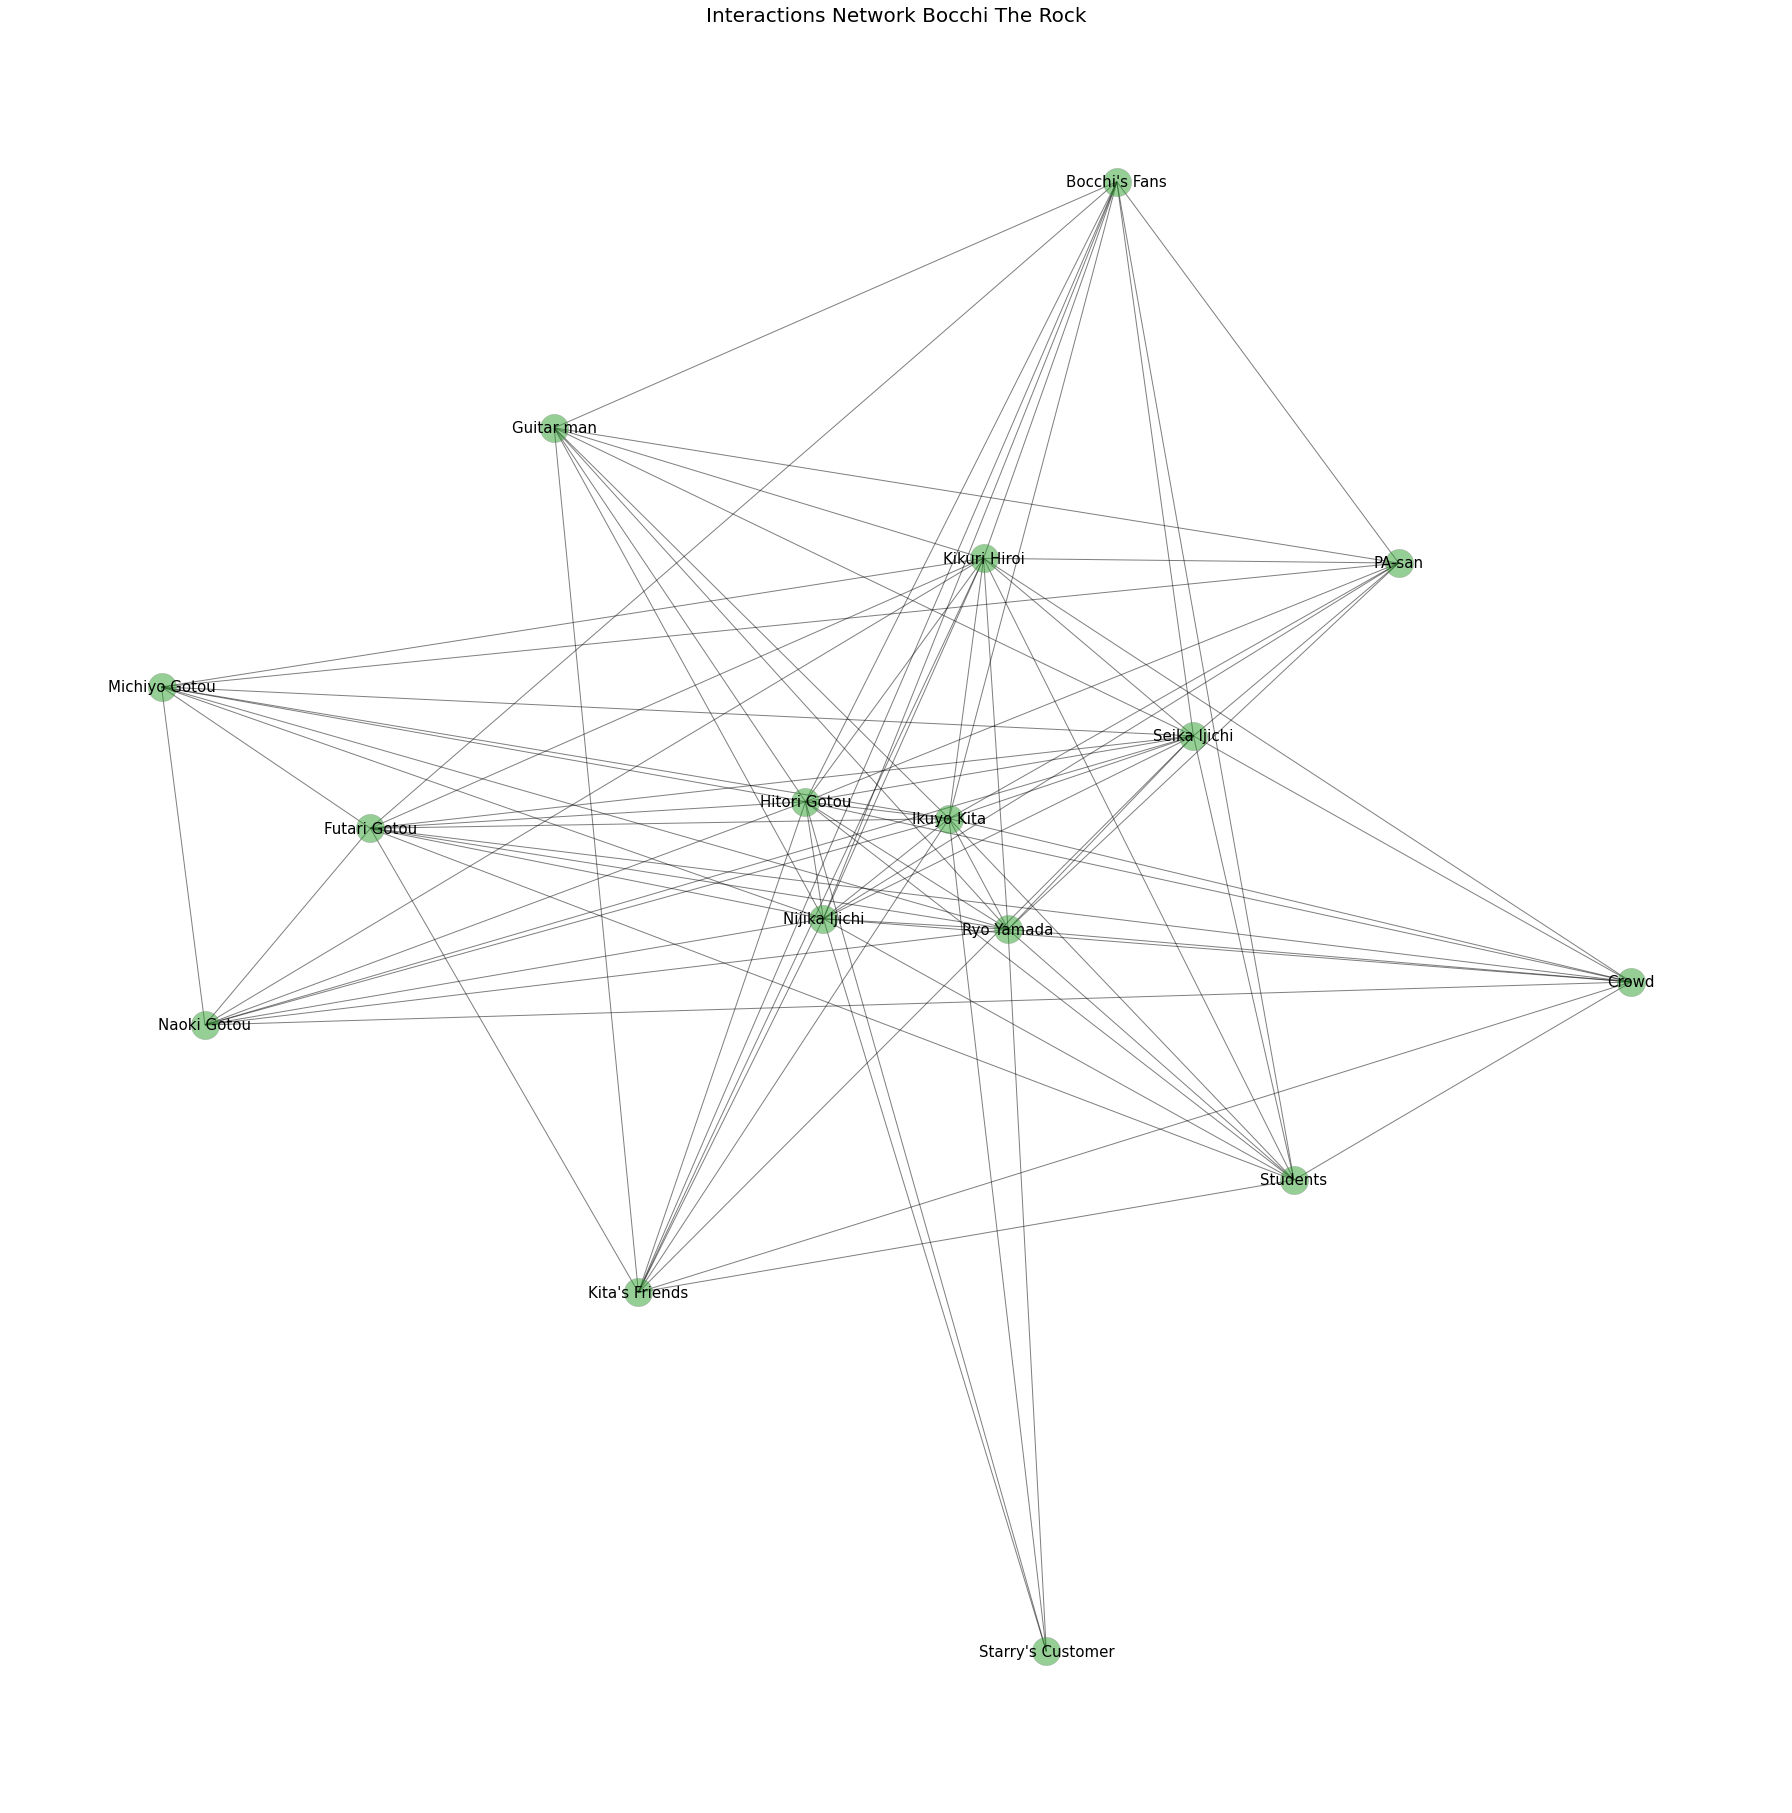

In [ ]:
draw_one_graph(G[0], 'Interactions Network Bocchi The Rock')

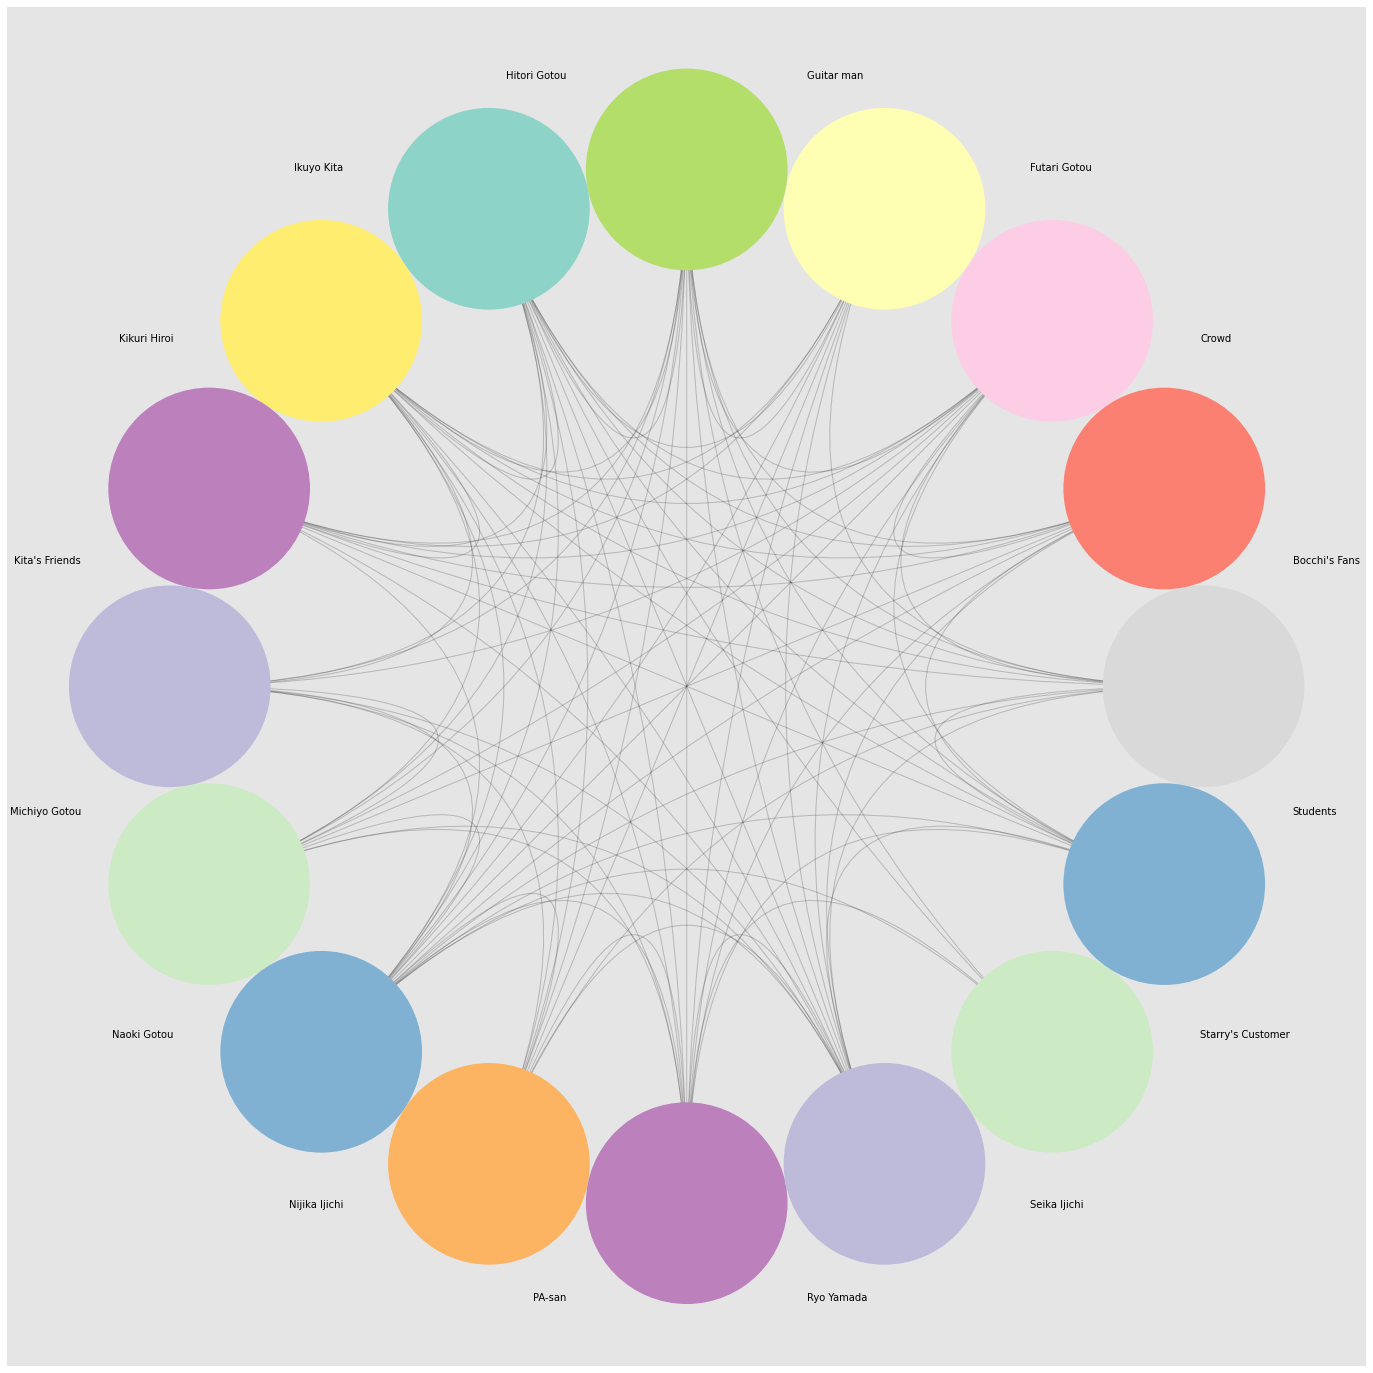

In [ ]:
draw_circle_graph(G[0], 'Interactions Network Bocchi The Rock')

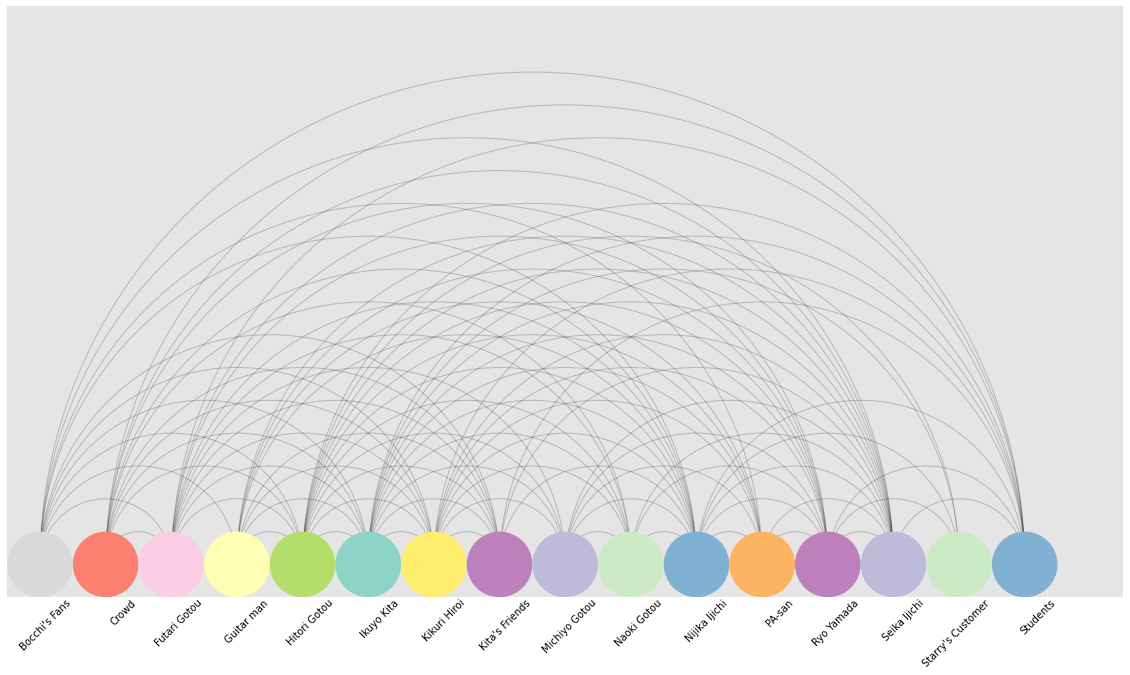

In [ ]:
draw_arc_graph(G[0], 'Interactions Network Bocchi The Rock')

In [ ]:
# convert from NetworkX to igraph
net = []
net.append(ig.Graph.from_networkx(G[0]))

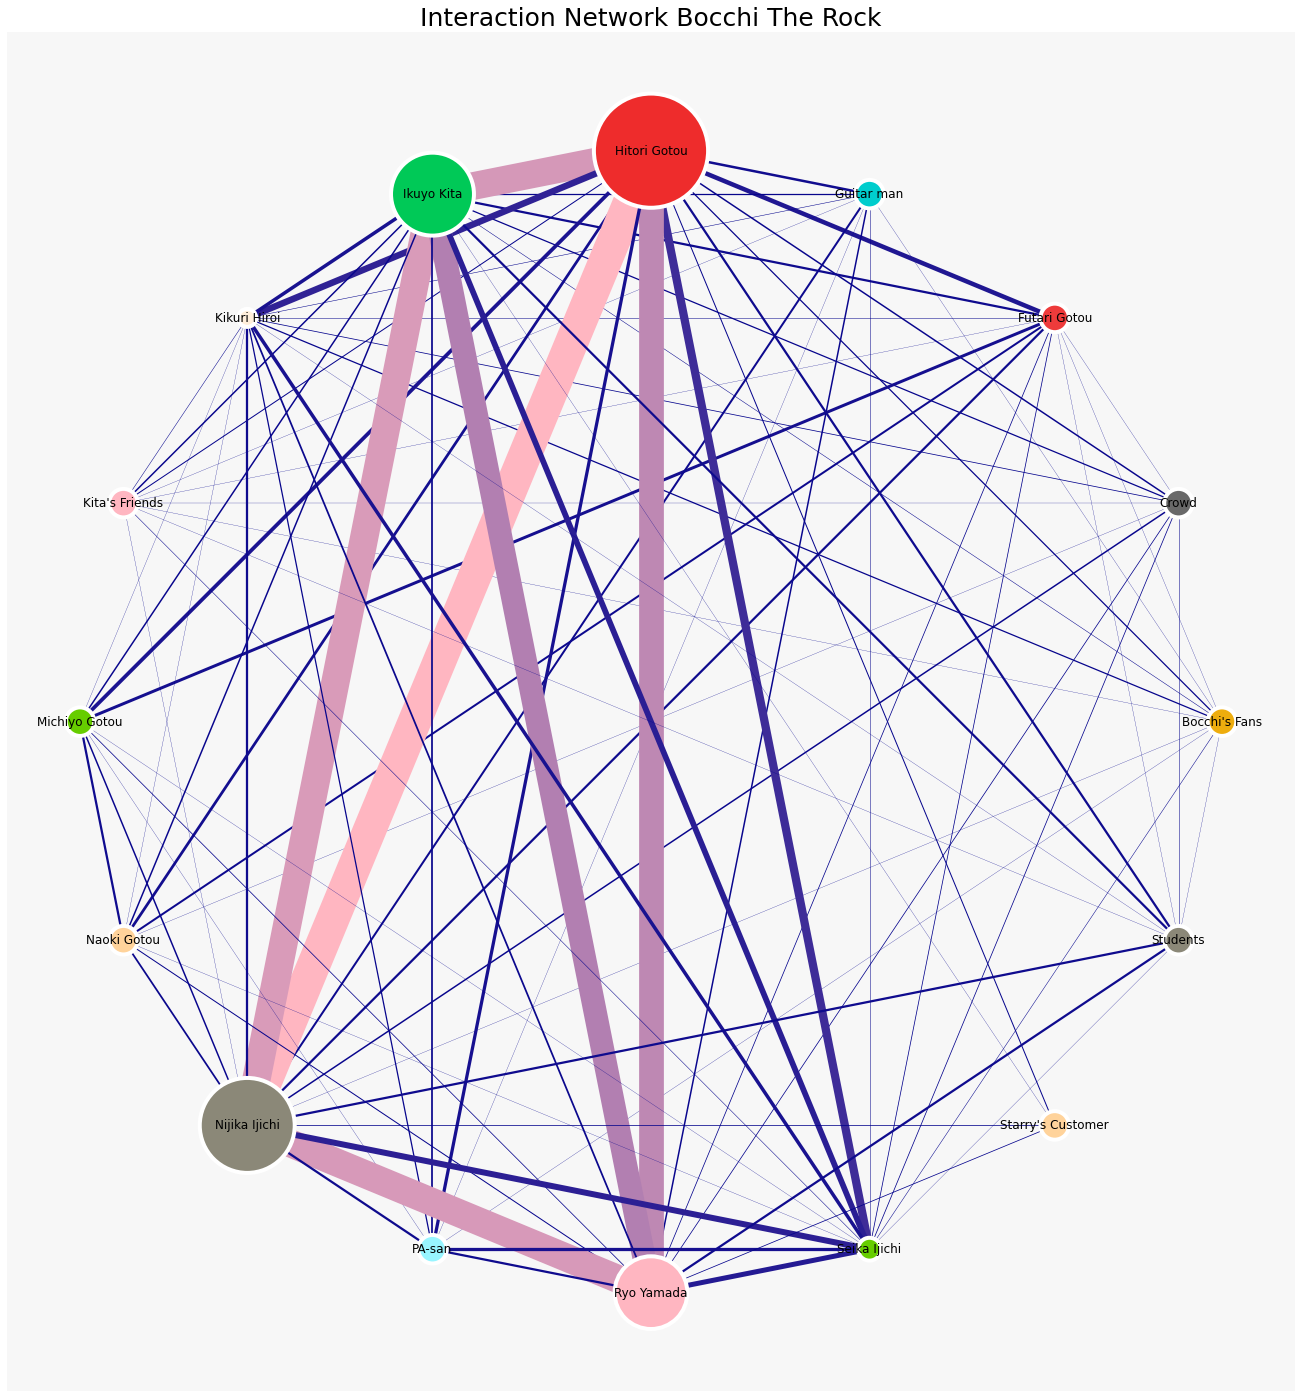

In [ ]:
draw_graph_with_features(net[0], size=25)

##8.- Other Sentiment Analysis

In [ ]:
df_comments = pd.read_csv("/content/Bocchi-The-Rock-Script-Analysis/Comments_Bocchi_The_Rock.txt", sep=";")
df_songs = pd.read_csv("/content/Bocchi-The-Rock-Script-Analysis/Songs_Bocchi_The_Rock_S1.txt", sep=";")
df_videos = pd.read_csv("/content/Bocchi-The-Rock-Script-Analysis/Video_Descriptions_Bocchi_The_Rock_S1.txt", sep=";")

In [ ]:
df_videos.head()

Number  \
0       1   
1       2   
2       3   

                                                                                                                                                                                                   Video Description Lie  
0  I love my new job working at a music club! I'm super busy with showing my kohai the ropes! Here I'm trying a song by an artist a new friend of mine introduced me to! The mistakes in the solo are part of the charm!  
1                                                            Sorry I can't upload very often nowadays! High school's just been way too much fun! Next time I'll try a song I do all the time with my friends at karaoke!  
2                                                  This song's been a big hit with all my friends lately! I sing this all the time at karaoke! The chorus gets everyone sooo hype! o(^v^)o My boyfriend loves this song!

In [ ]:
df_comments['Dialogue_clean'] = df_comments['Clean'].apply(lambda x: x.lower())
df_comments['Dialogue_clean'] = df_comments['Dialogue_clean'].replace(exception_map, regex=True)
df_comments["Dialogue_clean"] = df_comments['Dialogue_clean'].str.replace('[^\w\s]',' ')
df_comments.Dialogue_clean = df_comments.Dialogue_clean.str.split().apply\
        (lambda x: ' '.join(item for item in x if item not in new_stopwords_list))
df_comments.Dialogue_clean = df_comments.Dialogue_clean.str.replace('  ', '')
df_comments['Dialogue_clean'] = df_comments['Dialogue_clean'].apply(nltk.word_tokenize)
df_comments['NumberOfWords'] = df_comments['Dialogue_clean'].str.len()
df_comments.head()

<ipython-input-158-3d41a12fd5dc>:3: FutureWarning:

The default value of regex will change from True to False in a future version.



Season  Episode     Comment  \
0       1        5  Comment 19   
1       1        5  Comment 20   
2       1        5  Comment 21   
3       1        5  Comment 22   
4       1        5  Comment 23   

                                                                                                                                                         Clean  \
0  Yoshio Mania  30 minutes ago Not sure when I last heard someone playing so clean? Amazing! You've got such confident chords, and very few picking mistakes.   
1                                                  mou rock  2 hours ago I love that neroooom sound in the chorus. Please tell me what equipment you're using.   
2                                                                                                    Aichi  1 hour ago I don't know the song but now I love it   
3                                                                          Shindo Goh 2 hours ago Need to do a face reveal soon. I want to see you everywhere.   
4  Aoi  30 minutes ago Pleased to meet you! You were super cool! Are you a prodigy? Your timbre is so clean and polished... And I bet you're cute, too (thinks   

                                                                                                                 Dialogue_clean  \
0  [yoshio, mania, 30, minutes, ago, sure, last, heard, someone, playing, clean, amazing, confident, chords, picking, mistakes]   
1                                     [mou, rock, 2, hours, ago, love, neroooom, sound, chorus, please, tell, equipment, using]   
2                                                                                       [aichi, 1, hour, ago, know, song, love]   
3                                                 [shindo, goh, 2, hours, ago, need, face, reveal, soon, want, see, everywhere]   
4                      [aoi, 30, minutes, ago, pleased, meet, super, cool, prodigy, timbre, clean, polished, bet, cute, thinks]   

   NumberOfWords  
0             16  
1             13  
2              7  
3             12  
4             15

In [ ]:
df_songs['Dialogue_clean'] = df_songs['Lyrics'].apply(lambda x: x.lower())
df_songs['Dialogue_clean'] = df_songs['Dialogue_clean'].replace(exception_map, regex=True)
df_songs["Dialogue_clean"] = df_songs['Dialogue_clean'].str.replace('[^\w\s]',' ')
df_songs.Dialogue_clean = df_songs.Dialogue_clean.str.split().apply\
        (lambda x: ' '.join(item for item in x if item not in new_stopwords_list))
df_songs.Dialogue_clean = df_songs.Dialogue_clean.str.replace('  ', '')
df_songs['Dialogue_clean'] = df_songs['Dialogue_clean'].apply(nltk.word_tokenize)
df_songs['NumberOfWords'] = df_songs['Dialogue_clean'].str.len()
df_songs.head()

<ipython-input-160-44a30acfc287>:3: FutureWarning:

The default value of regex will change from True to False in a future version.



Song       Voice          Band  Timeline  \
0                         Seishun Complex  Ikuyo Kita  Kessoku Band         1   
1                            Distortion!!  Ikuyo Kita  Kessoku Band         2   
2                                Karakara  Ryo Yamada  Kessoku Band         3   
3  Guitar, Solitude, and the Blue Planet!  Ikuyo Kita  Kessoku Band         4   
4                   Original unnamed song  Ikuyo Kita  Kessoku Band         5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Lyrics  \
0                                                                                                                                                                                                                                                                                                I liked dark, cramped spaces, so I'd bury my face deep in my hood My eyes resented the heartless world, but yearned for love I liked being soaked by the rain, because my face looked better clouded over I pretended to be afraid of the storm while waiting for the sky to burst Strum through the light's distortion I want to make thunder roar Drum beyond the pain What can I do? This fierce pounding is out of control Strum in a harmonizing quartet I want to cause a revolution Drum in a lamenting forte What can I do? My savage nature is beyond wild   
1  The tune that plays when my loneliness and the pedal are stepped on Tracks down my cheeks over and over again The pounding of my loneliness Is joined by the rhythm of the snare drum To create a solid pulse Someone, please remove the distortion on my heart And take a look inside me Nobody can get inside my heart But it's the kind of night when I hope someone will Distortion it's Motion Once it starts, there's no stopping it Limits can be overwritten with experience Isn't that right? Distortion is always like that My heart takes off, outpacing my left brain Toward where you are An escort to the next note Distortion on my day-to-day anguish The chord I play when I'm alone at night Is it the same for you? I spent all those days chasing my ideal image Play an F chord with distortion So loud that the needle swings off the scale   
2                                                                                                                                                                                                                                                          I sleep, with big problems weighing down on me Though you can't beat that feeling of being loved, it's true When I awaken from cold dreams, my body feels numb You shine so brightly, it could make me a shadow It's time to take that step Though there's nothing certain about it It carries my childish heart into tomorrow It's time to blast out the thoughts rattling around in my brain And live, to its fullest, a life I've been taking advances on for so long But I also love the days I spend lying around, doing nothing So I know I'm going to go see you Before it all disappears some day   
3                                                                                                      A sudden evening shower falls And yeah, it figures, I don't have an umbrella... Who car

In [ ]:
df_videos['Dialogue_clean'] = df_videos['Video Description Lie'].apply(lambda x: x.lower())
df_videos['Dialogue_clean'] = df_videos['Dialogue_clean'].replace(exception_map, regex=True)
df_videos["Dialogue_clean"] = df_videos['Dialogue_clean'].str.replace('[^\w\s]',' ')
df_videos.Dialogue_clean = df_videos.Dialogue_clean.str.split().apply\
        (lambda x: ' '.join(item for item in x if item not in new_stopwords_list))
df_videos.Dialogue_clean = df_videos.Dialogue_clean.str.replace('  ', '')
df_videos['Dialogue_clean'] = df_videos['Dialogue_clean'].apply(nltk.word_tokenize)
df_videos['NumberOfWords'] = df_videos['Dialogue_clean'].str.len()
df_videos.head()

<ipython-input-162-c07985a81497>:3: FutureWarning:

The default value of regex will change from True to False in a future version.



Number  \
0       1   
1       2   
2       3   

                                                                                                                                                                                                   Video Description Lie  \
0  I love my new job working at a music club! I'm super busy with showing my kohai the ropes! Here I'm trying a song by an artist a new friend of mine introduced me to! The mistakes in the solo are part of the charm!   
1                                                            Sorry I can't upload very often nowadays! High school's just been way too much fun! Next time I'll try a song I do all the time with my friends at karaoke!   
2                                                  This song's been a big hit with all my friends lately! I sing this all the time at karaoke! The chorus gets everyone sooo hype! o(^v^)o My boyfriend loves this song!   

                                                                                                                                                 Dialogue_clean  \
0  [love, new, job, working, music, club, super, busy, showing, kohai, ropes, trying, song, artist, new, friend, mine, introduced, mistakes, solo, part, charm]   
1                                                 [sorry, upload, often, nowadays, high, school, way, much, fun, next, time, try, song, time, friends, karaoke]   
2                                         [song, big, hit, friends, lately, sing, time, karaoke, chorus, gets, everyone, sooo, hype, v, boyfriend, loves, song]   

   NumberOfWords  
0             22  
1             16  
2             17

In [ ]:
vader_comments = df_comments
vader_comments["Clean"] = vader_comments["Clean"].str.replace('[^\w\s]','')

vader_videos = df_videos
vader_videos["Video Description Lie"] = vader_videos["Video Description Lie"].str.replace('[^\w\s]','')

vader_songs = df_songs
vader_songs["Lyrics"] = vader_songs["Lyrics"].str.replace('[^\w\s]','')


vader_comments['Score']=vader_comments['Clean'].apply(lambda x: sid.polarity_scores(x))
vader_videos['Score']=vader_videos['Video Description Lie'].apply(lambda x: sid.polarity_scores(x))
vader_songs['Score']=vader_songs['Lyrics'].apply(lambda x: sid.polarity_scores(x))


# Place scores in own columns
vader_comments['CompScore']=vader_comments.Score.apply(lambda x: x.get("compound"))
vader_comments['PosScore']=vader_comments.Score.apply(lambda x: x.get("pos"))
vader_comments['NegScore']=vader_comments.Score.apply(lambda x: x.get("neg"))
vader_comments['NeuScore']=vader_comments.Score.apply(lambda x: x.get("neu"))

vader_videos['CompScore']=vader_videos.Score.apply(lambda x: x.get("compound"))
vader_videos['PosScore']=vader_videos.Score.apply(lambda x: x.get("pos"))
vader_videos['NegScore']=vader_videos.Score.apply(lambda x: x.get("neg"))
vader_videos['NeuScore']=vader_videos.Score.apply(lambda x: x.get("neu"))

vader_songs['CompScore']=vader_songs.Score.apply(lambda x: x.get("compound"))
vader_songs['PosScore']=vader_songs.Score.apply(lambda x: x.get("pos"))
vader_songs['NegScore']=vader_songs.Score.apply(lambda x: x.get("neg"))
vader_songs['NeuScore']=vader_songs.Score.apply(lambda x: x.get("neu"))

# With scores extracted, the original score field can be removed
vader_comments = vader_comments.drop(['Score'], axis=1)
vader_videos = vader_videos.drop(['Score'], axis=1)
vader_songs = vader_songs.drop(['Score'], axis=1)

<ipython-input-164-2258f88231aa>:2: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-164-2258f88231aa>:5: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-164-2258f88231aa>:8: FutureWarning:

The default value of regex will change from True to False in a future version.



In [ ]:
vader_videos.head()

Number  \
0       1   
1       2   
2       3   

                                                                                                                                                                                             Video Description Lie  \
0  I love my new job working at a music club Im super busy with showing my kohai the ropes Here Im trying a song by an artist a new friend of mine introduced me to The mistakes in the solo are part of the charm   
1                                                            Sorry I cant upload very often nowadays High schools just been way too much fun Next time Ill try a song I do all the time with my friends at karaoke   
2                                                     This songs been a big hit with all my friends lately I sing this all the time at karaoke The chorus gets everyone sooo hype ovo My boyfriend loves this song   

                                                                                                                                                 Dialogue_clean  \
0  [love, new, job, working, music, club, super, busy, showing, kohai, ropes, trying, song, artist, new, friend, mine, introduced, mistakes, solo, part, charm]   
1                                                 [sorry, upload, often, nowadays, high, school, way, much, fun, next, time, try, song, time, friends, karaoke]   
2                                         [song, big, hit, friends, lately, sing, time, karaoke, chorus, gets, everyone, sooo, hype, v, boyfriend, loves, song]   

   NumberOfWords  CompScore  PosScore  NegScore  NeuScore  
0             22     0.9100     0.267     0.048     0.686  
1             16     0.5106     0.186     0.119     0.696  
2             17     0.7783     0.201     0.000     0.799

In [ ]:
vader_videos['CompScore'].mean()

0.7329666666666667

In [ ]:
vader_comments['CompScore'].mean()

0.43950434782608705

In [ ]:
vader_comments['PosFlag'] = vader_comments.CompScore.apply(lambda x: 1 if x >= 0.05 else 0)
vader_comments['NegFlag'] = vader_comments.CompScore.apply(lambda x: 1 if x <= -0.05 else 0)
vader_comments['NeuFlag'] = vader_comments.CompScore.apply(lambda x: 1 if x < 0.05 and x > -0.05 else 0)

In [ ]:
vader_comments['PosFlag'].sum()

17

In [ ]:
vader_comments['NegFlag'].sum()

2

In [ ]:
songs_values = vader_songs.groupby(['Song','Band']).mean()['CompScore'].reset_index(name='mean')

In [ ]:
songs_values

Song          Band    mean
0                            Distortion!!  Kessoku Band  0.7615
1  Guitar, Solitude, and the Blue Planet!  Kessoku Band  0.0770
2                     I will never forget  Kessoku Band  0.3166
3                                Karakara  Kessoku Band  0.1726
4                           Nani ga Warui  Kessoku Band -0.8957
5                   Original unnamed song  Kessoku Band  0.2474
6                         Seishun Complex  Kessoku Band  0.5574
7                          Sick Hack song     Sick Hack  0.7684
8               To Become a Constellation  Kessoku Band  0.9524

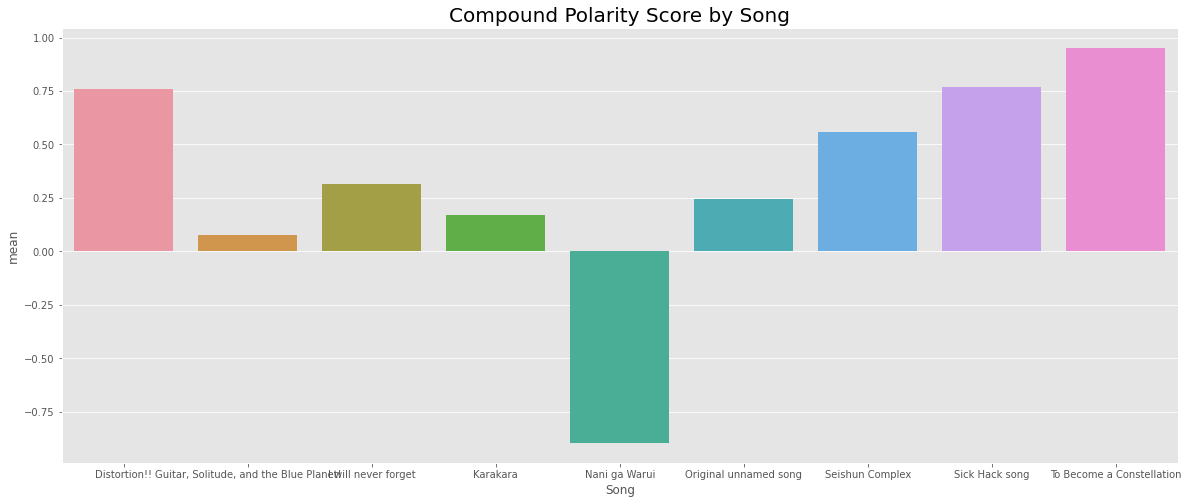

In [ ]:
fig, ax = pyplot.subplots(figsize=(20,8))
sns.barplot(ax=ax, data=songs_values, x = 'Song', y = 'mean')
ax.set_title('Compound Polarity Score by Song', size=20)
plt.savefig("polarity by Song.png", format="png", bbox_inches = 'tight')
plt.show()

In [ ]:
song_nrc = df_songs
song_nrc = song_nrc.explode('Dialogue_clean')
song_nrc = song_nrc.drop(['Lyrics','NumberOfWords'], axis=1)
song_nrc = song_nrc.rename(columns={'Dialogue_clean':'Word'})

In [ ]:
song_nrc_analysis = pd.merge(song_nrc,sentiment_final, on='Word') #A quick merge
song_sentiment = song_nrc_analysis.groupby(['Emotion']).size().reset_index(name='Value')
song_sentiment = song_sentiment.set_index('Emotion').T
#Lets see the overall result.
song_sentiment.head()

Emotion  anger  anticipation  disgust  fear  joy  negative  positive  sadness  \
Value       20            26       12    29   30        64        54       30   

Emotion  surprise  trust  
Value          21     21

<ipython-input-190-1b14221708ae>:19: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



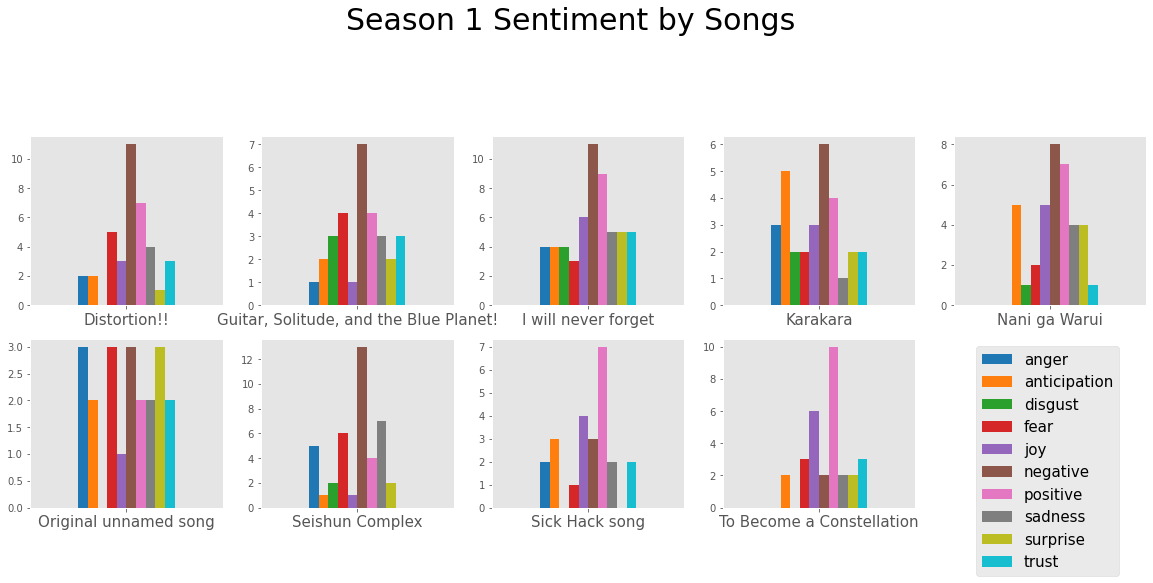

In [ ]:
songs_sentiment = song_nrc_analysis
songs_sentiment = songs_sentiment.groupby(['Song','Emotion']).size().reset_index(name='Value')
songs_sentiment = songs_sentiment.pivot_table(columns='Emotion', values='Value', fill_value=0, index='Song')

songs = songs_sentiment.index.tolist() #I needed a fixed order, so I created a new list
labels_songs = songs_sentiment.columns.tolist()

plt.figure(figsize=(20,18))
plt.subplots_adjust(hspace=0.2)
plt.suptitle("Season 1 Sentiment by Songs", fontsize=30)

for n, char in enumerate(songs):
  ax = plt.subplot(5,5,n+1)
  songs_sentiment[songs_sentiment.index==char].plot(kind='bar',ax=ax)
  ax.set_xlabel('')
  ax.set_xticklabels(ax.get_xticklabels(),rotation=0, fontsize=15)
  ax.legend().remove()

plt.legend(ax, labels=labels_songs, loc='upper right', bbox_to_anchor=(2.1,1), fontsize=15)

plt.savefig("Sentiment by Song.png", format="png", bbox_inches = 'tight')
plt.show()

##9.- Topic Modeling

In [ ]:
df_songs['Lemmatized'] = df_songs['Dialogue_clean'].apply(
                    lambda lst:[lemmatizer.lemmatize(word) for word in lst])

In [ ]:
data_words = df_songs.Lemmatized.values.tolist()
print(data_words)

[['liked', 'dark', 'cramped', 'space', 'bury', 'face', 'deep', 'hood', 'eye', 'resented', 'heartless', 'world', 'yearned', 'love', 'liked', 'soaked', 'rain', 'face', 'looked', 'better', 'clouded', 'pretended', 'afraid', 'storm', 'waiting', 'sky', 'burst', 'strum', 'light', 'distortion', 'want', 'make', 'thunder', 'roar', 'drum', 'beyond', 'pain', 'fierce', 'pounding', 'control', 'strum', 'harmonizing', 'quartet', 'want', 'cause', 'revolution', 'drum', 'lamenting', 'forte', 'savage', 'nature', 'beyond', 'wild'], ['tune', 'play', 'loneliness', 'pedal', 'stepped', 'track', 'cheek', 'pounding', 'loneliness', 'joined', 'rhythm', 'snare', 'drum', 'create', 'solid', 'pulse', 'someone', 'please', 'remove', 'distortion', 'heart', 'take', 'look', 'inside', 'nobody', 'inside', 'heart', 'kind', 'night', 'hope', 'someone', 'distortion', 'motion', 'start', 'stopping', 'limit', 'overwritten', 'experience', 'right', 'distortion', 'always', 'like', 'heart', 'take', 'outpacing', 'left', 'brain', 'toward

In [ ]:
!pip install pyldavis

In [ ]:
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import os
import pickle 
import pyLDAvis

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [ ]:
# number of topics
num_topics = 4
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin in

In [ ]:
pprint(lda_model.print_topics())

[(0,
  '0.012*"sound" + 0.011*"like" + 0.010*"night" + 0.010*"constellation" + '
  '0.010*"become" + 0.009*"could" + 0.009*"time" + 0.009*"let" + 0.009*"day" + '
  '0.008*"wrong"'),
 (1,
  '0.015*"time" + 0.014*"know" + 0.010*"sound" + 0.010*"let" + 0.010*"like" + '
  '0.009*"life" + 0.009*"feeling" + 0.008*"die" + 0.008*"day" + '
  '0.007*"around"'),
 (2,
  '0.023*"distortion" + 0.015*"heart" + 0.012*"day" + 0.012*"play" + '
  '0.011*"drum" + 0.011*"like" + 0.009*"want" + 0.008*"someone" + 0.008*"take" '
  '+ 0.008*"night"'),
 (3,
  '0.016*"let" + 0.016*"way" + 0.011*"round" + 0.009*"know" + 0.008*"sound" + '
  '0.008*"time" + 0.008*"could" + 0.008*"night" + 0.008*"like" + '
  '0.007*"dream"')]


In [ ]:
# Visualize the topics
vis_data = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [ ]:
vis_data = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis_data, 'Bocchi The Rock topic model.html')

##10.- Words in Songs

In [ ]:
song_words = df_songs.explode('Lemmatized')
song_words = song_words.groupby(['Lemmatized'])['Lemmatized'].value_counts().to_frame(name='Frequency')
song_words = song_words.sort_values(by = 'Frequency', ascending=False)
song_words.head(10)

Frequency
Lemmatized Lemmatized           
like       like                8
time       time                7
day        day                 7
let        let                 7
sound      sound               7
distortion distortion          6
night      night               6
know       know                6
want       want                5
could      could               5